# Simplified-Workflow ver9

eyes open


C:\Users\joshua.park\AppData\Local\Temp\ipykernel_14924\1213014564.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  averaged_data = average_across_arrays(torch.tensor(training_data_open).detach())


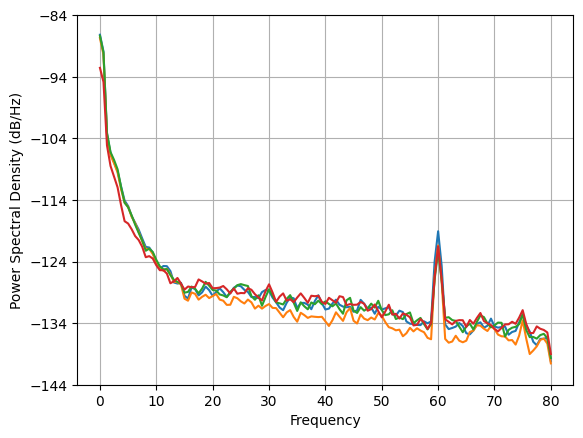

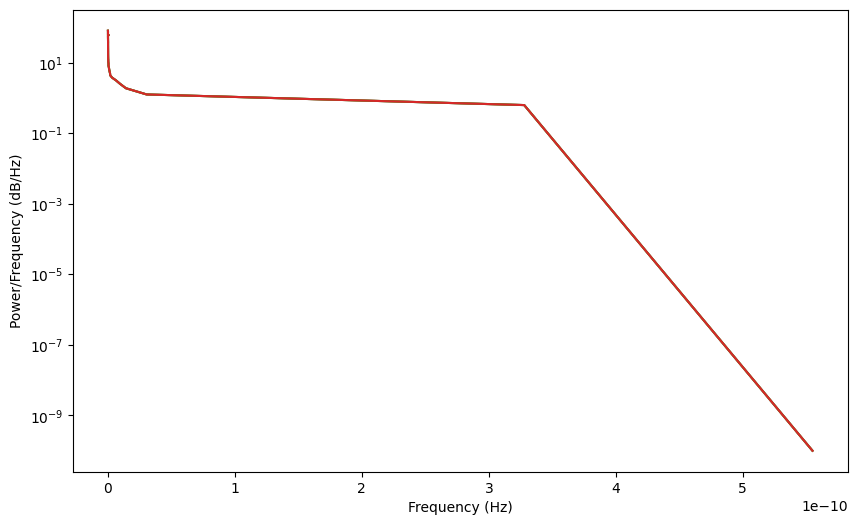

eyes closed


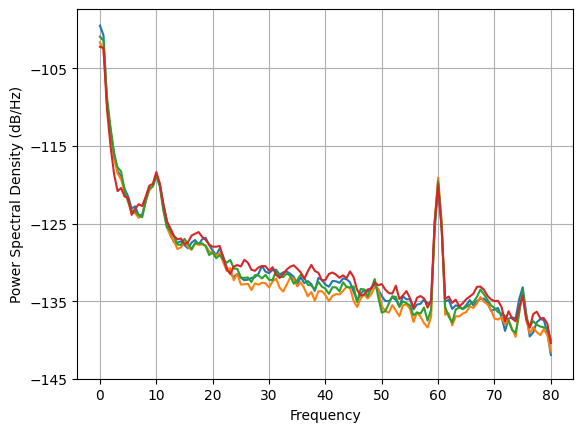

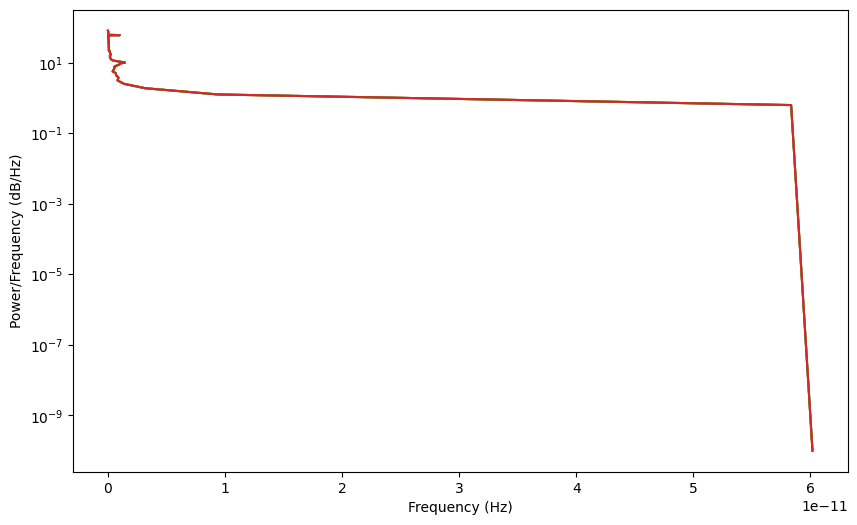

In [5]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


eyes_open = np.load('training_open.npy')
eyes_closed = np.load('training_closed.npy')

training_data_open = []
training_data_closed = []

for i in range(len(eyes_open)):
    aux = []
    for ch in [21,22,23,27]:
        aux.append(eyes_open[i,ch,:])
    training_data_open.append(aux)

for i in range(len(eyes_closed)):
    aux = []
    for ch in [21,22,23,27]:
        aux.append(eyes_closed[i,ch,:])
    training_data_closed.append(aux)


eyes_open = None
eyes_closed = None

NUM_CHANNELS = 4
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5


def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=nperseg, noverlap=noverlap)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd

def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)

# Set the sampling frequency
fs = 160.0

## open data
averaged_data = average_across_arrays(torch.tensor(training_data_open).detach())
freqs, psd = compute_psd(averaged_data, fs)
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(NUM_CHANNELS):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

print("eyes open")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()



## closed data
averaged_data = average_across_arrays(torch.tensor(training_data_closed).detach())
freqs, psd = compute_psd(averaged_data, fs)
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(NUM_CHANNELS):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

print("eyes closed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()


def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()
    
    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    averaged_data = average_across_arrays(generated_data)
    freqs, psd = compute_psd(averaged_data, fs)
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(NUM_CHANNELS):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# 4 best channels as training data

Epoch 0: Critic error ([-0.6483262013430188]) Generator err ([1.7425475120544434])


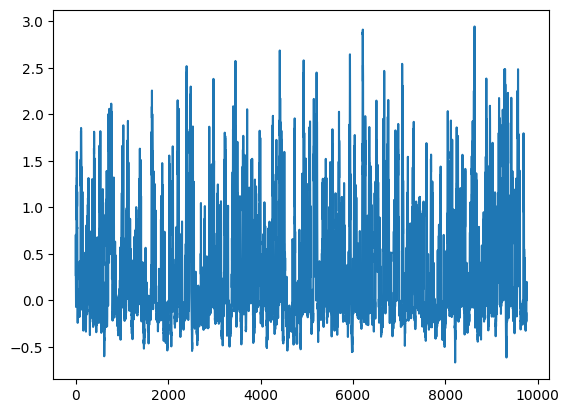

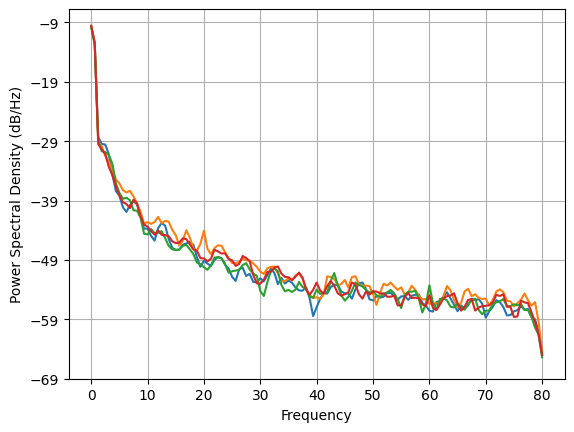

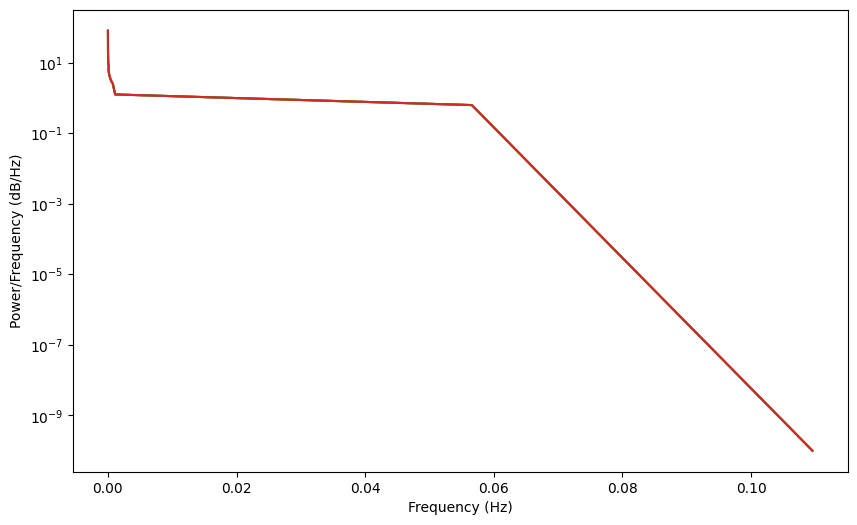

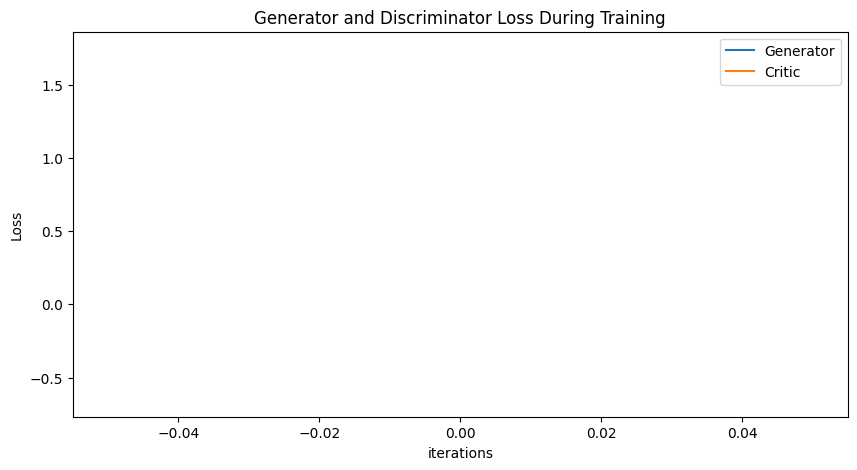

Epoch 10: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237]) Generator err ([1.7425475120544434, 4.8232421875, 12.427712440490723, 39.686214447021484, 24.426555633544922, 50.02964401245117, 37.51876449584961, 48.94606018066406, 36.46565628051758, 41.87841796875, 33.6678352355957])


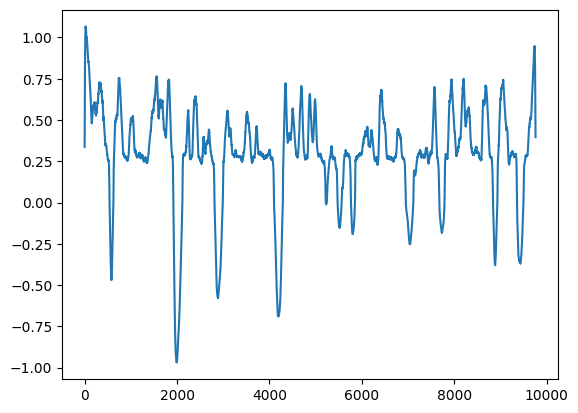

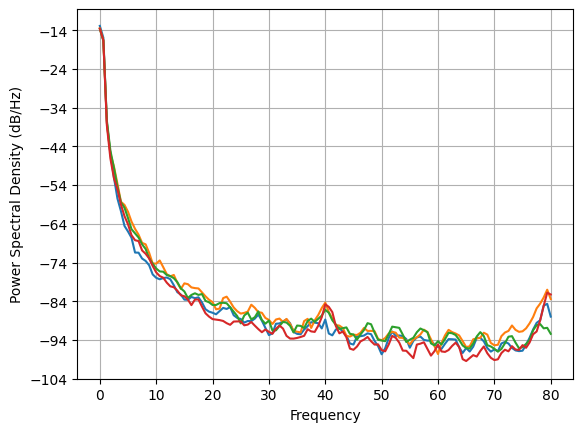

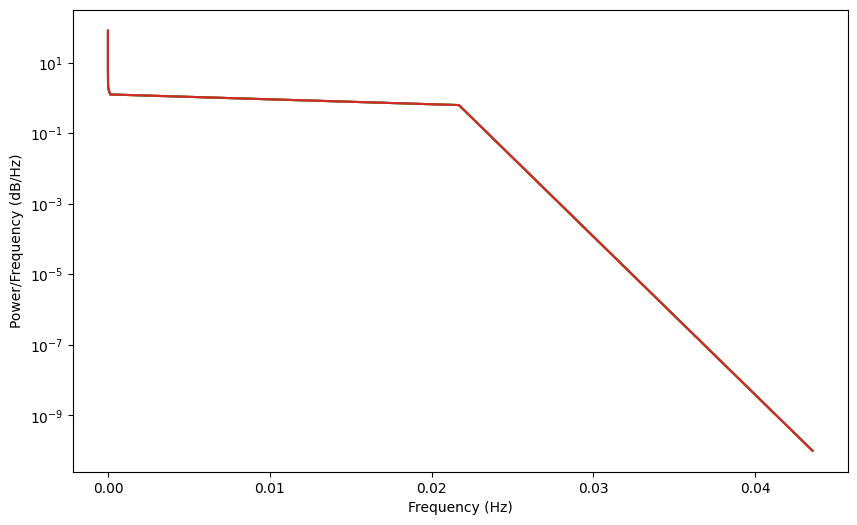

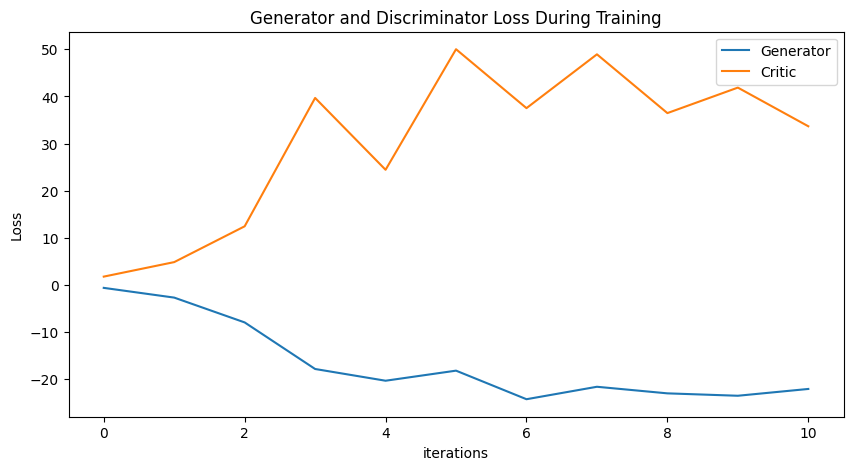

Epoch 20: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242]) Generator err ([1.7425475120544434, 4.8232421875, 12.427712440490723, 39.686214447021484, 24.426555633544922, 50.02964401245117, 37.51876449584961, 48.94606018066406, 36.46565628051758, 41.87841796875, 33.6678352355957, 36.8375129699707, 45.68250274658203, 24.47857093811035, 57.773651123046875, 40.2187385559082, 35.75928497314453, 61.70024108886719, 50.79689407348633, 45.863094329833984, 40.56794738769531])


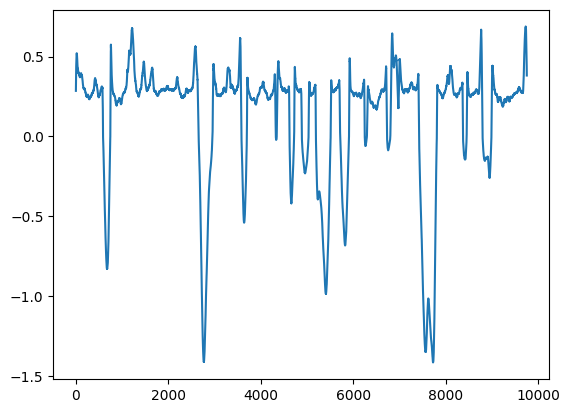

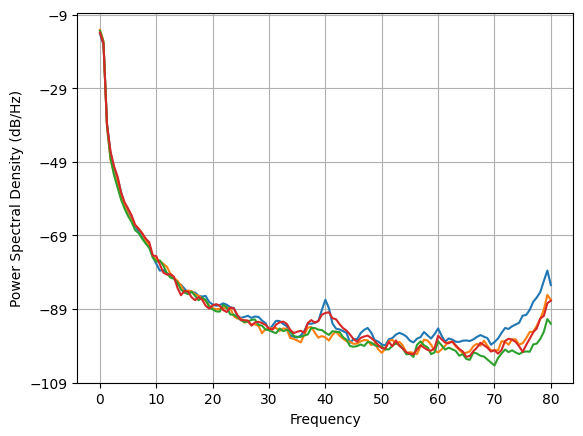

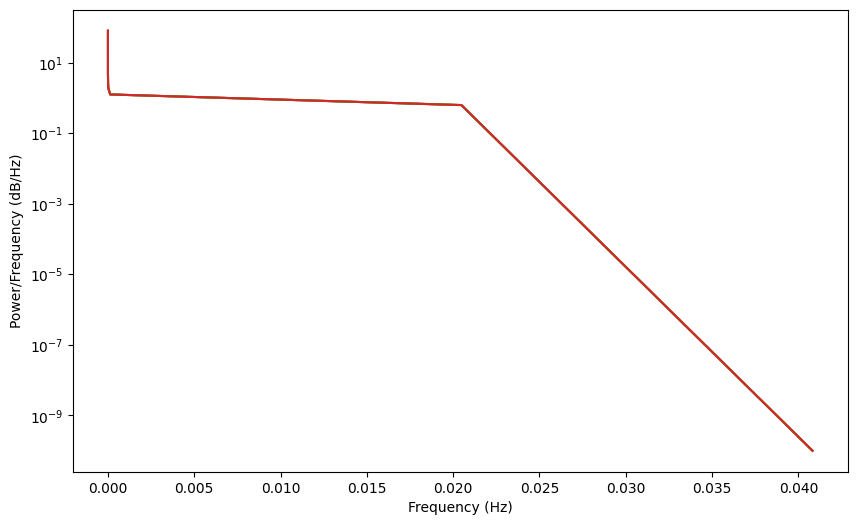

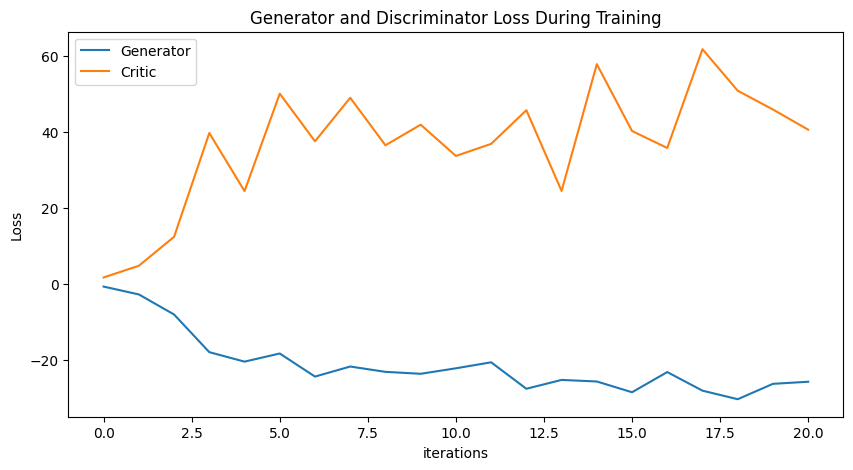

Epoch 30: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046]) Generator err ([1.7425475120544434, 4.8232421875, 12.427712440490723, 39.686214447021484, 24.426555633544922, 50.02964401245117, 37.51876449584961, 48.94606018066406, 36.46565628051758, 41.87841796875, 33.6678352355957, 36.8375129699707, 45.68250274658203, 24.47857093811035, 57.773651123046875, 40.2187385559082, 35.75928497314453, 

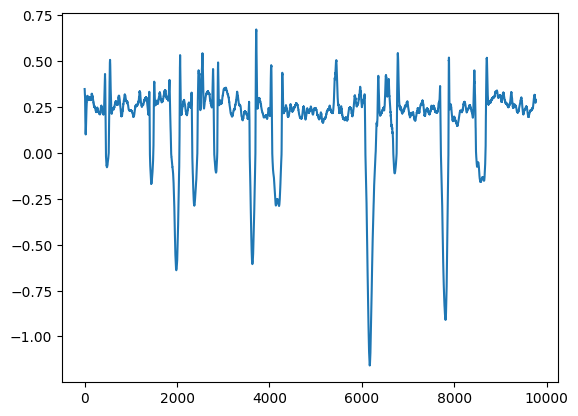

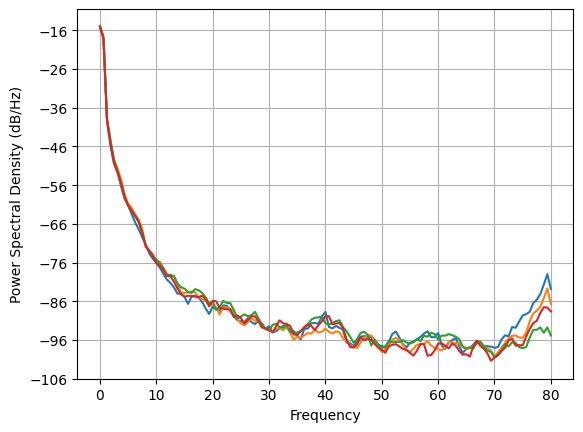

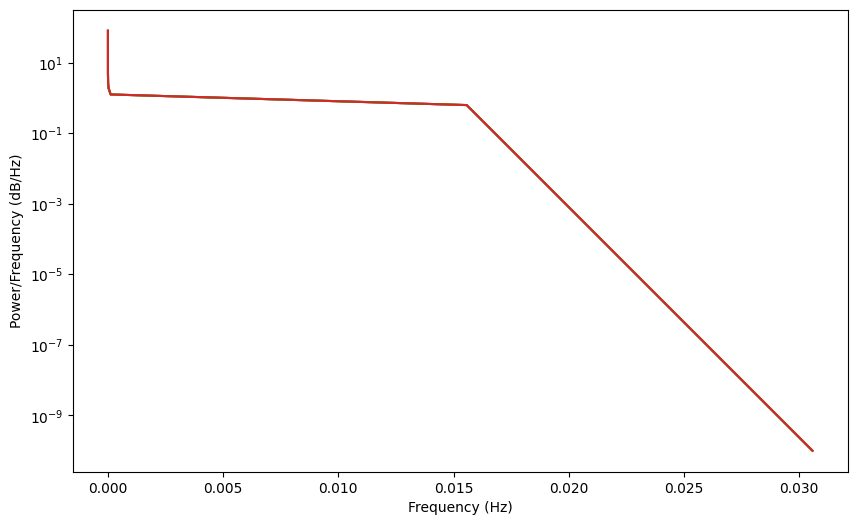

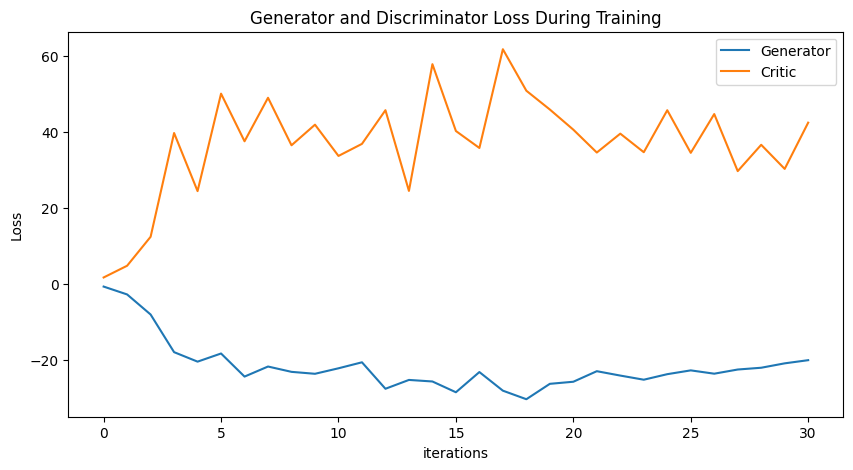

Epoch 40: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218]) Generator err ([1.7425475120544434, 4.8232421875, 12.427712440490723, 39.686214447021484, 24.426555633544922, 50.02964401245117

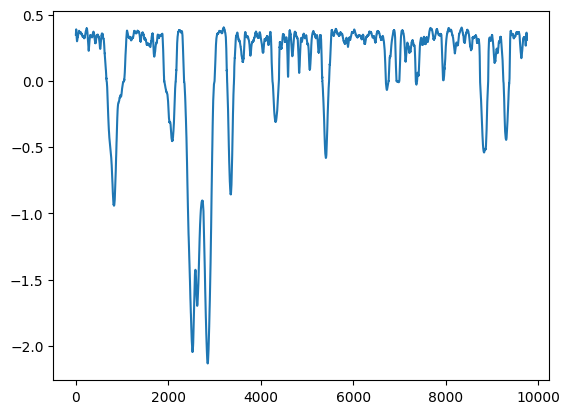

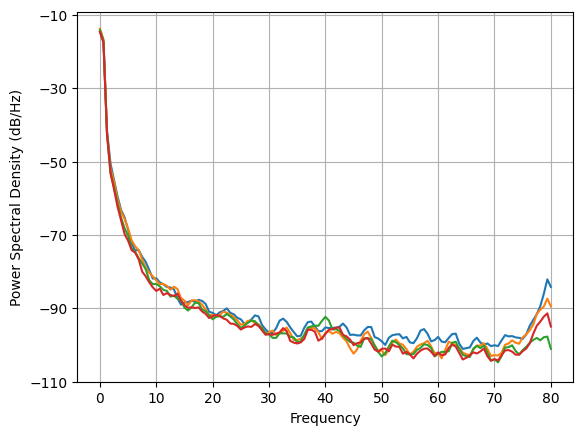

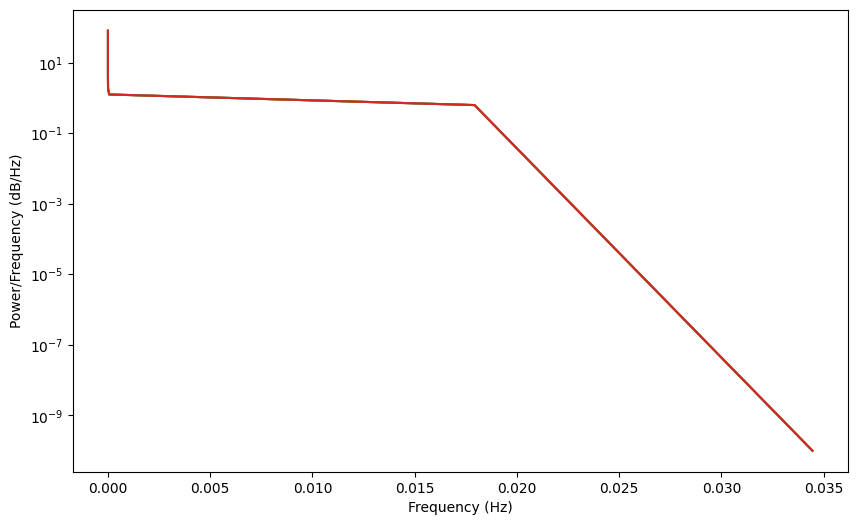

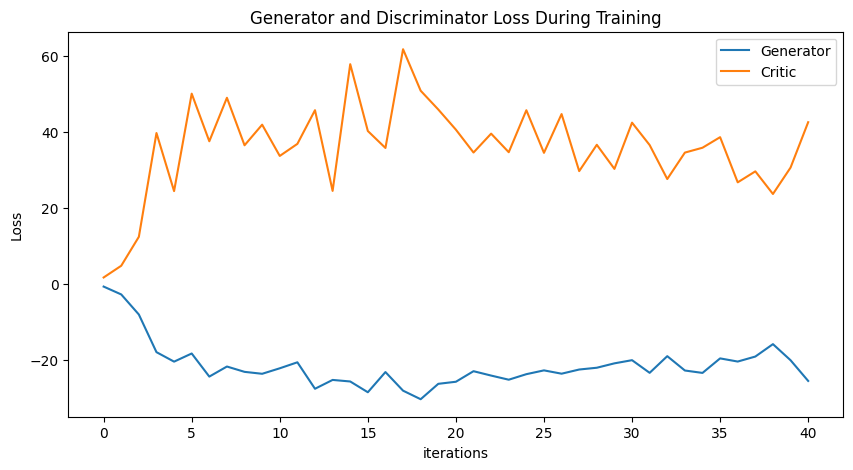

Epoch 50: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.14

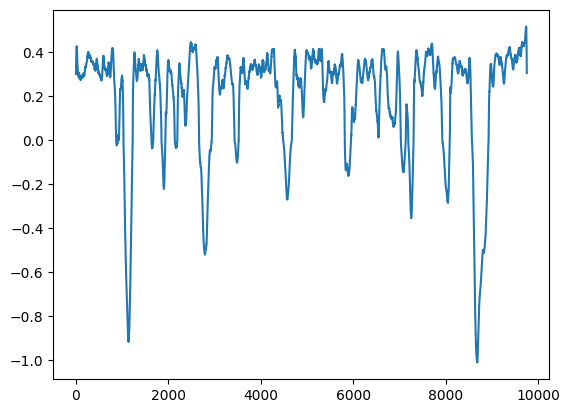

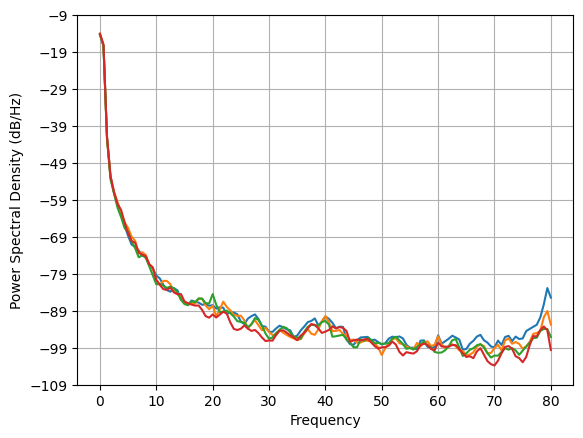

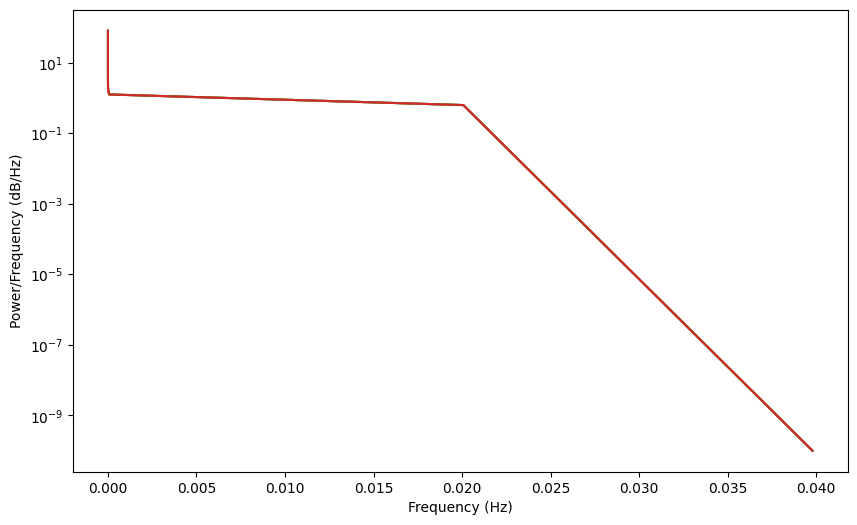

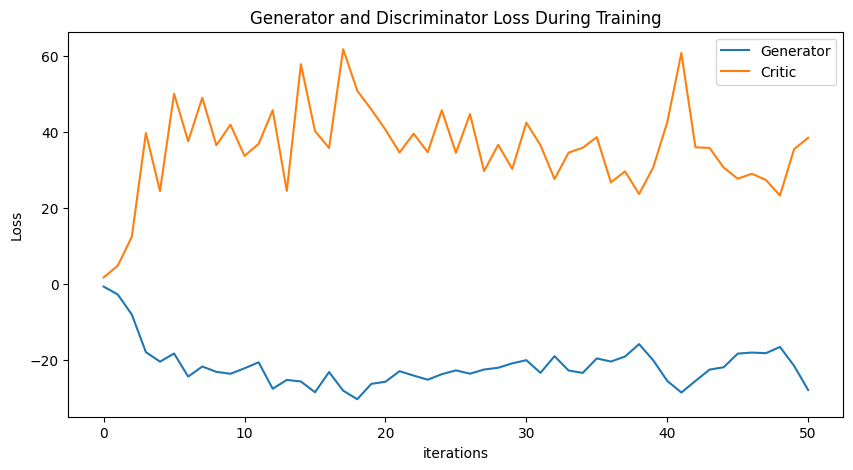

Epoch 60: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.14

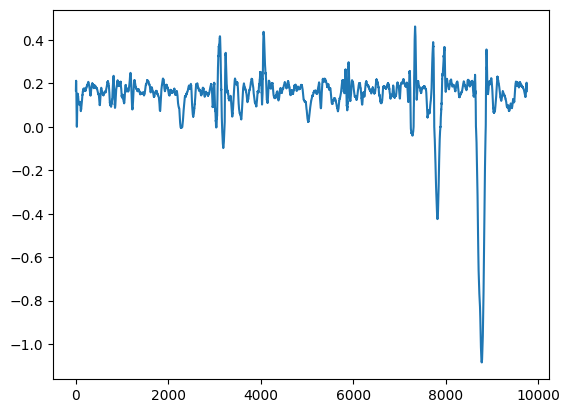

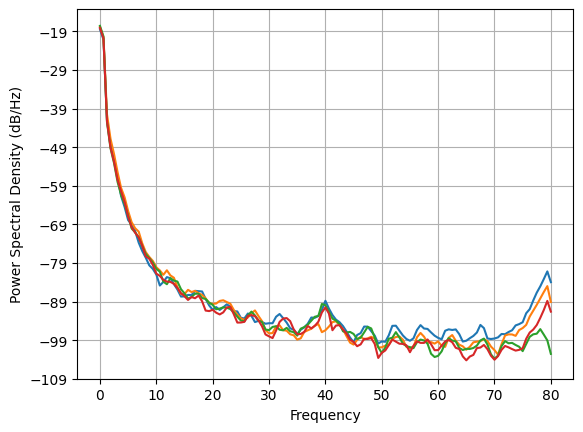

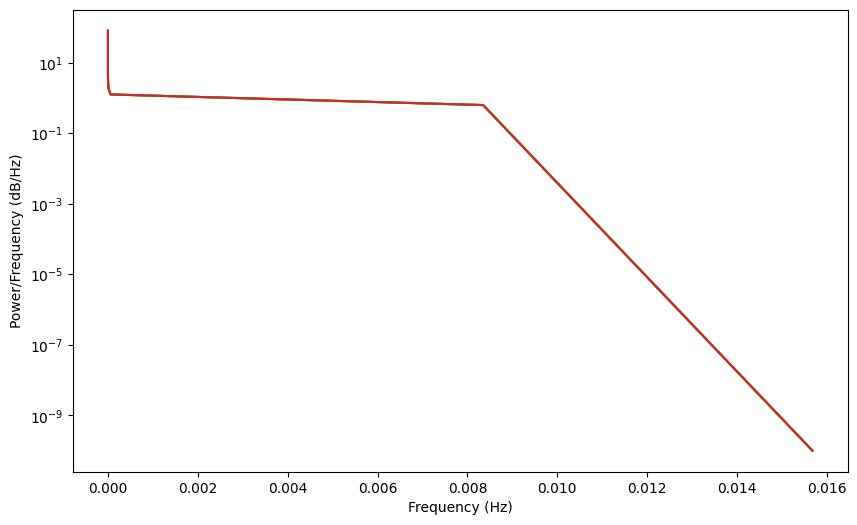

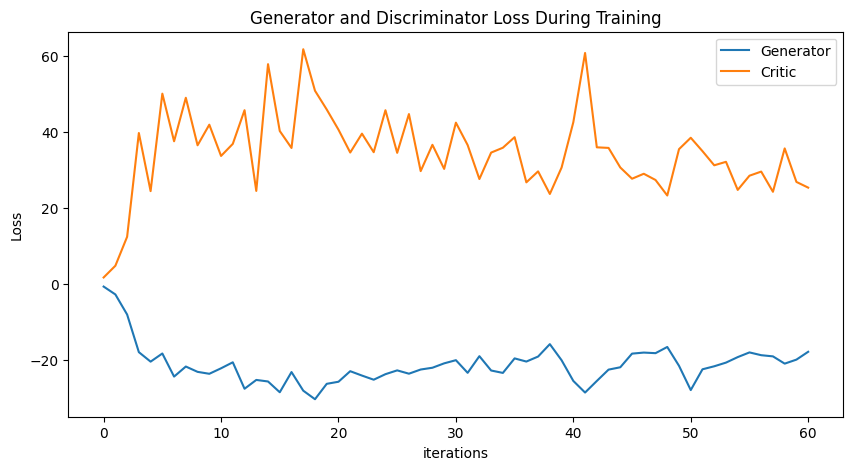

Epoch 70: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.14

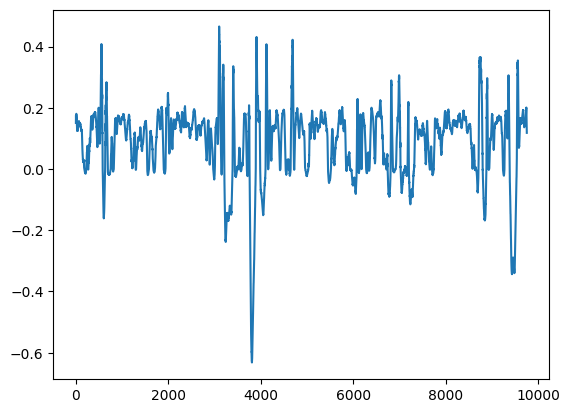

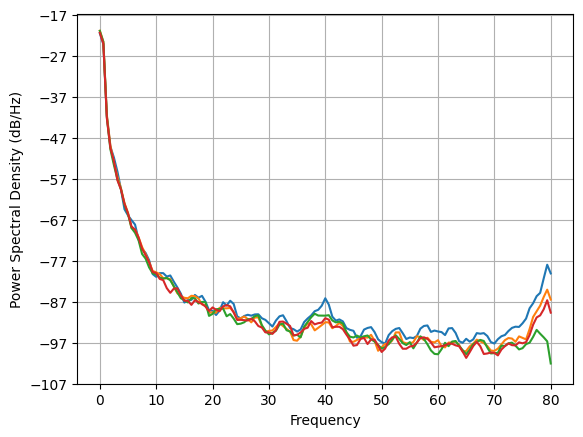

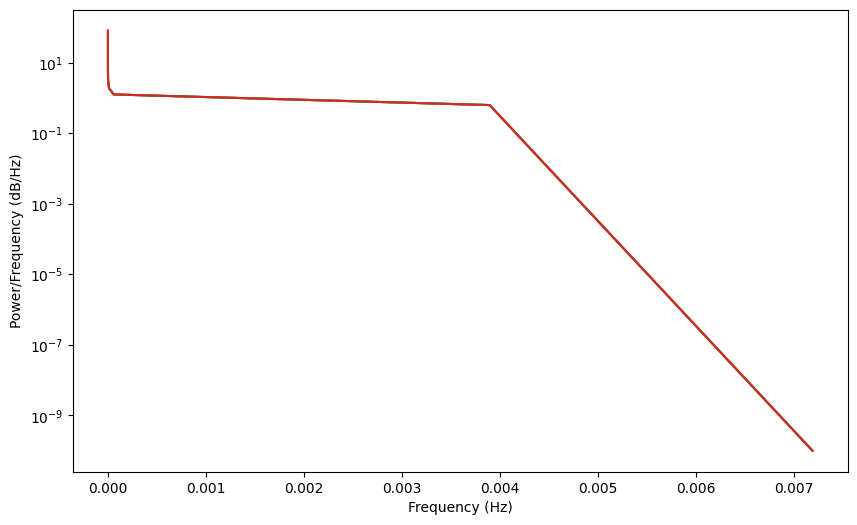

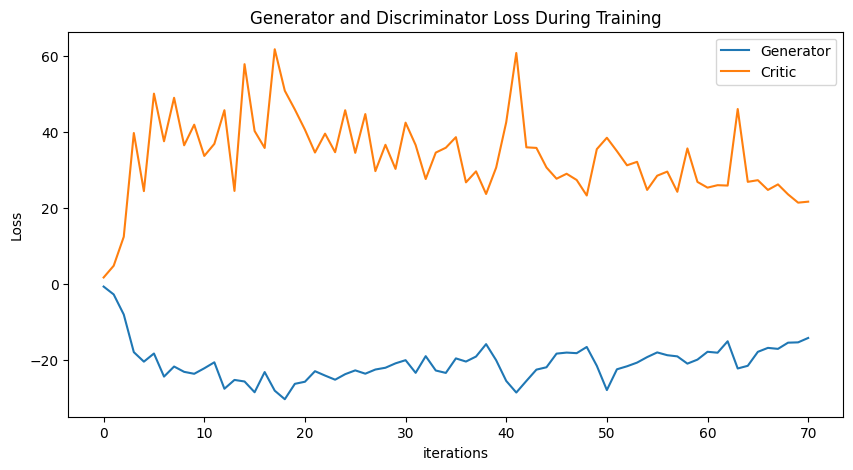

Epoch 80: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.14

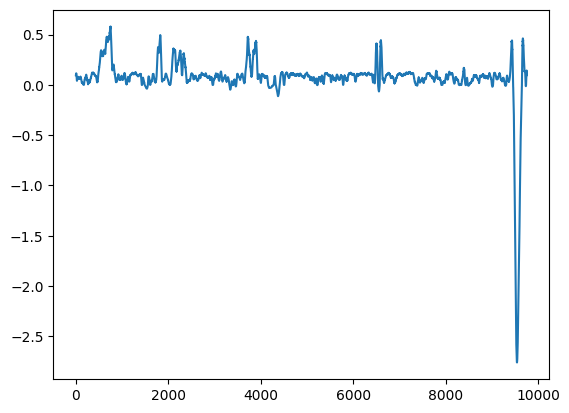

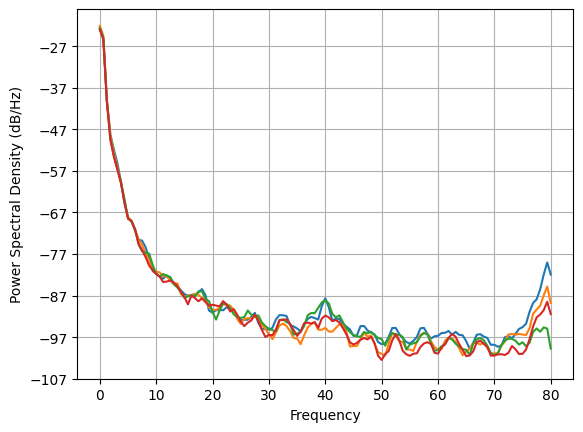

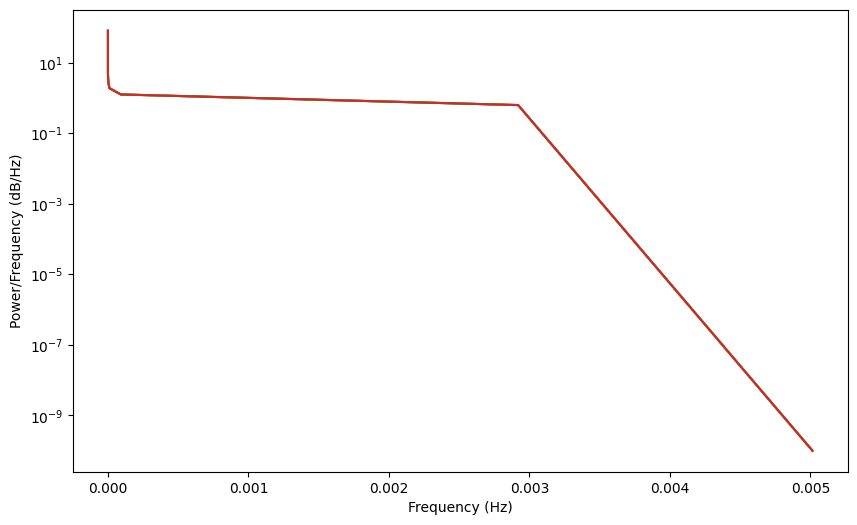

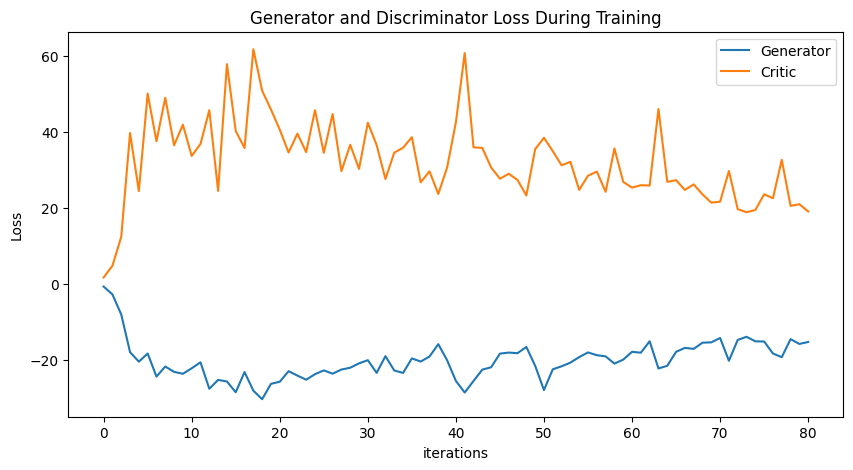

Epoch 90: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.14

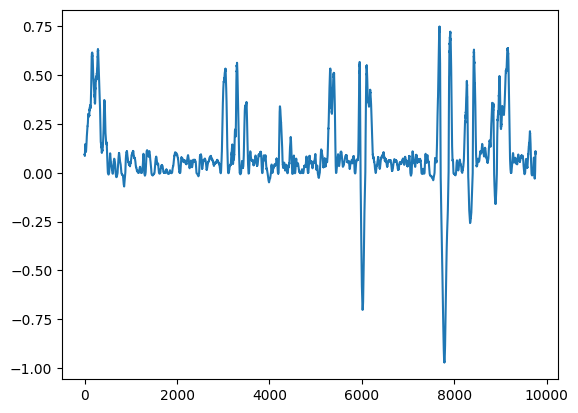

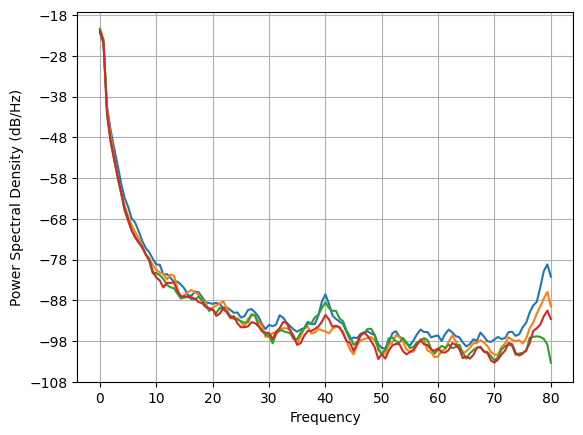

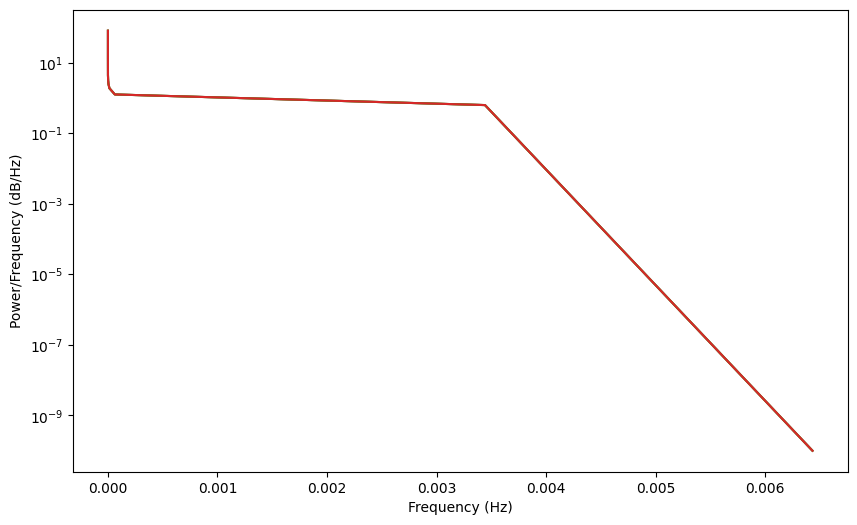

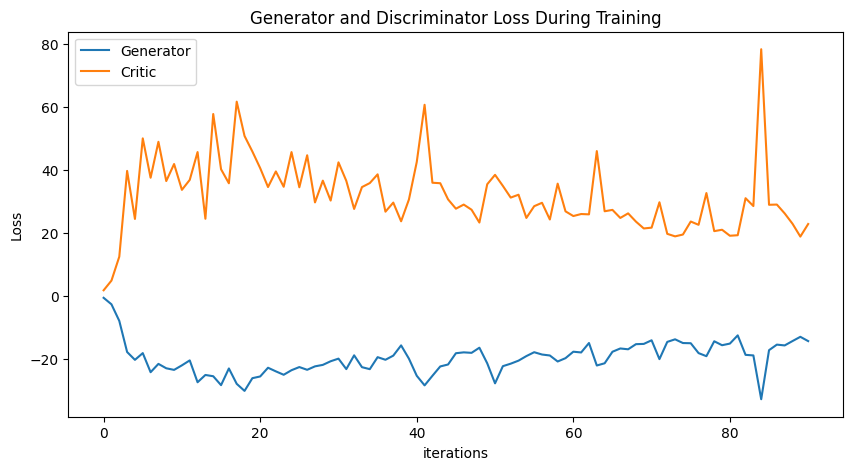

Epoch 100: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

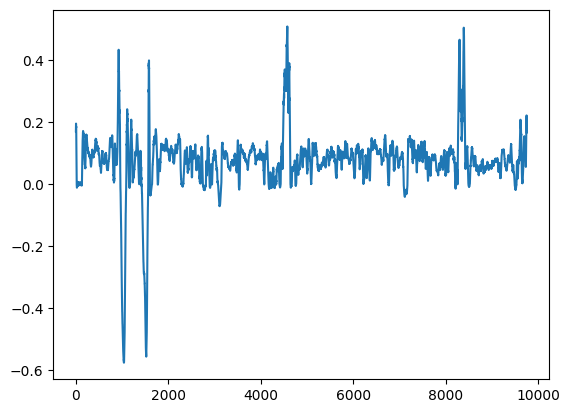

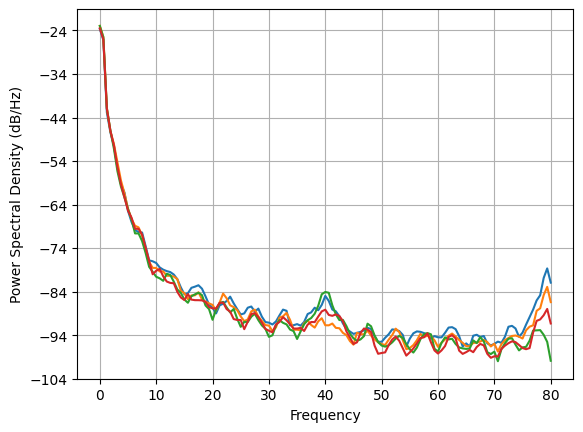

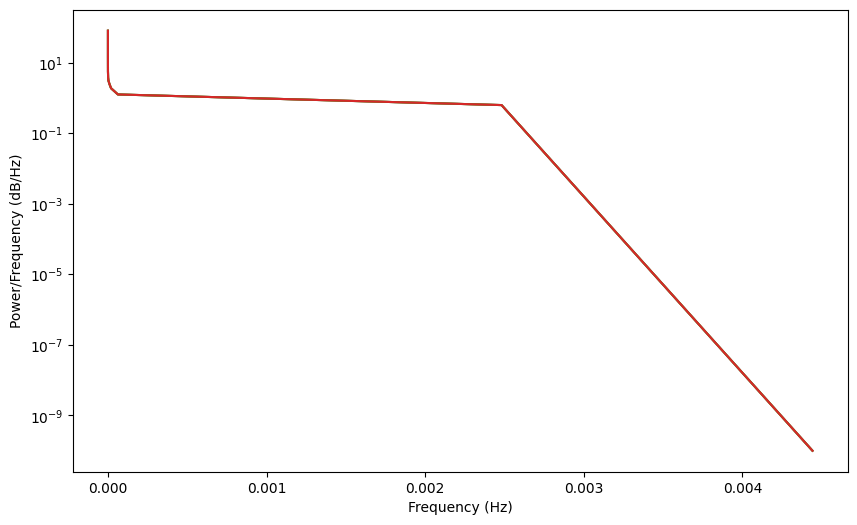

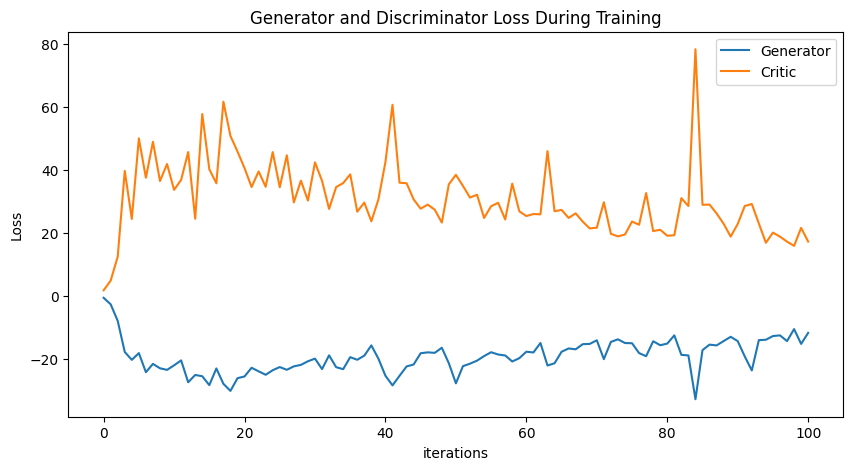

Epoch 110: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

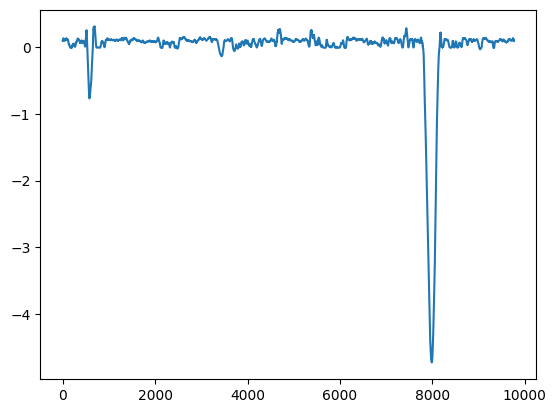

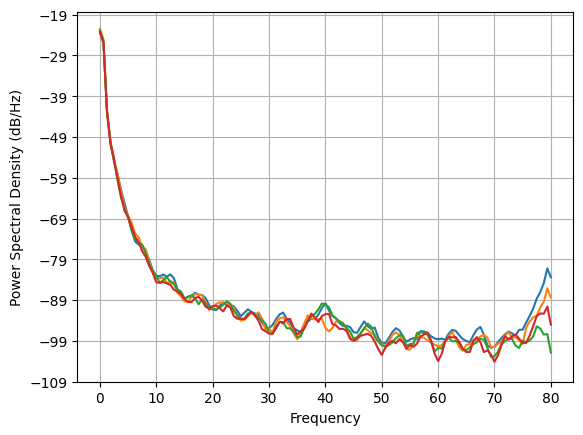

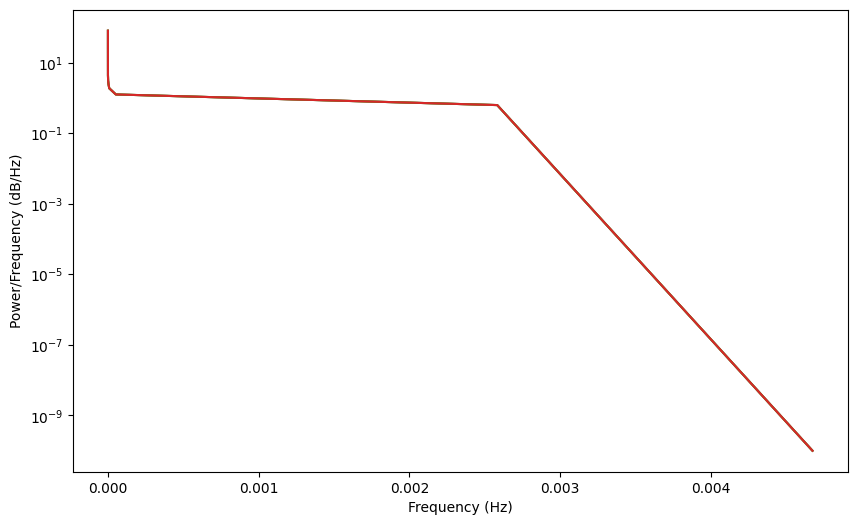

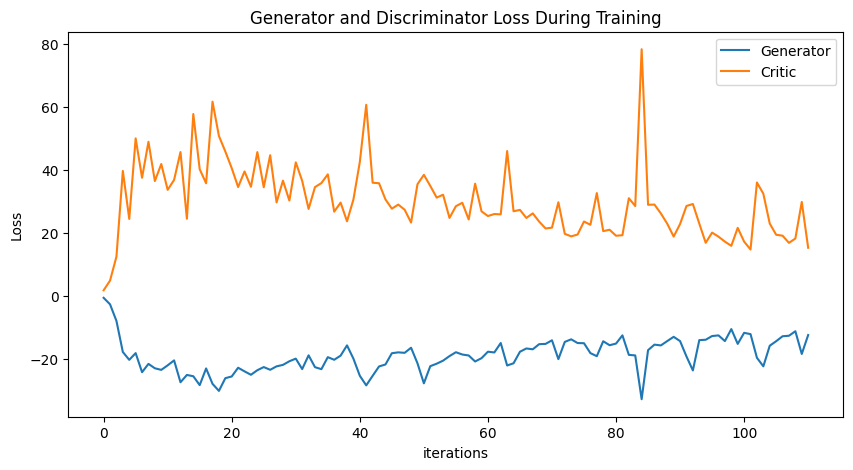

Epoch 120: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

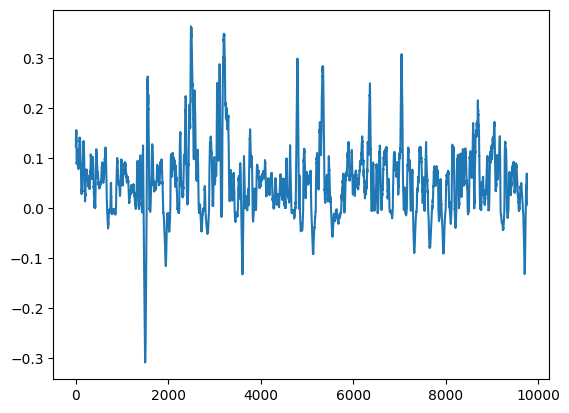

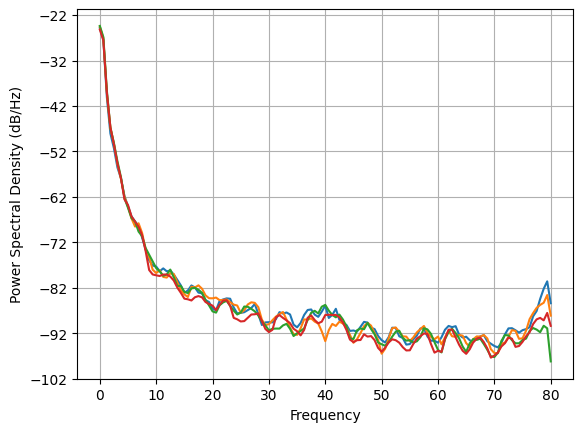

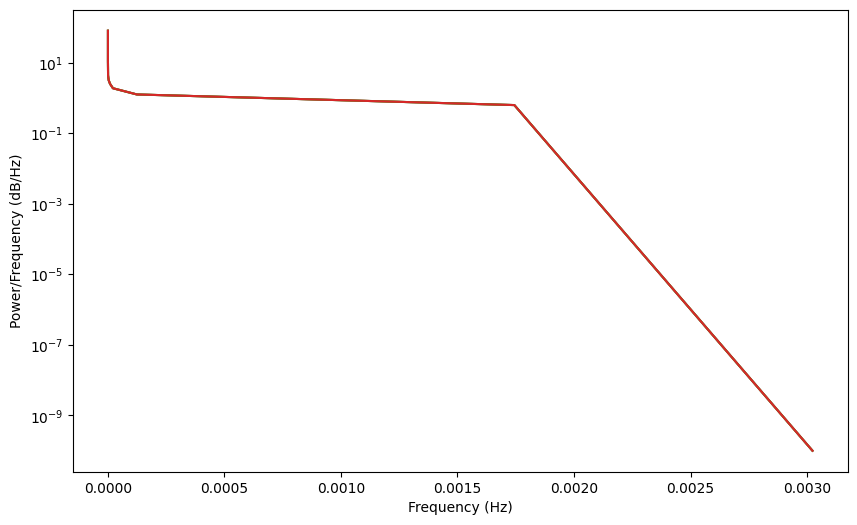

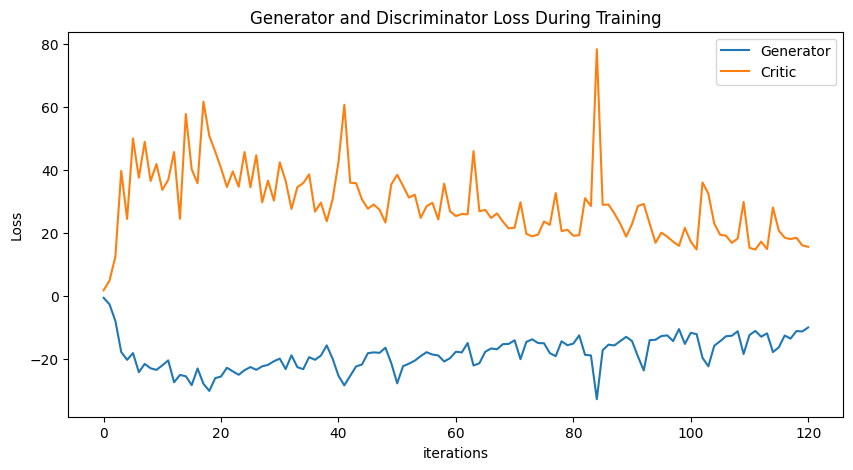

Epoch 130: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

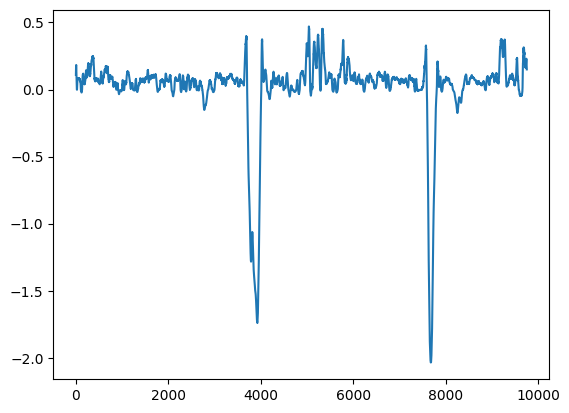

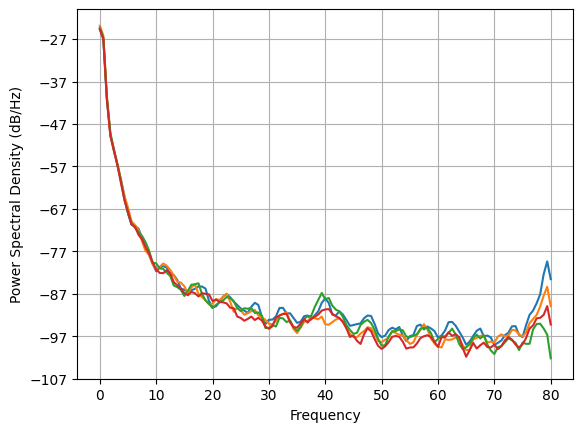

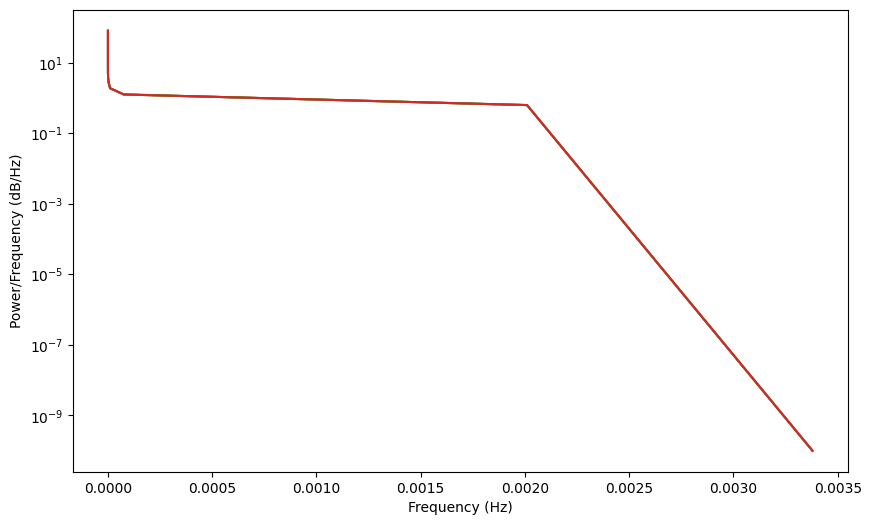

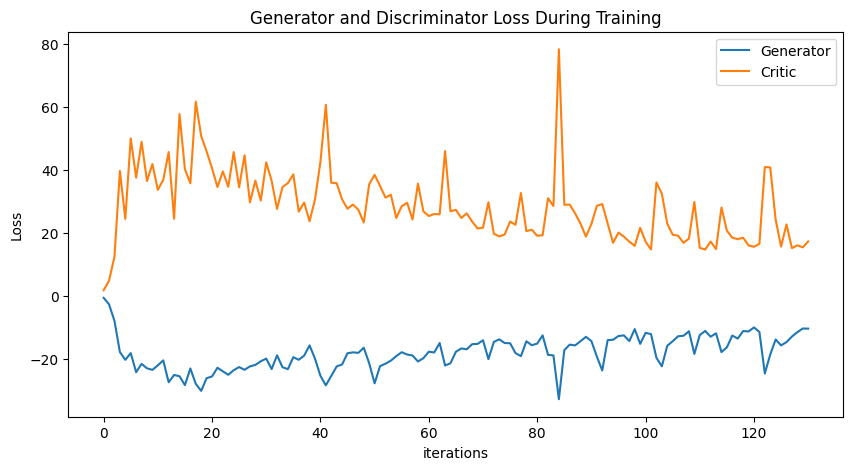

Epoch 140: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

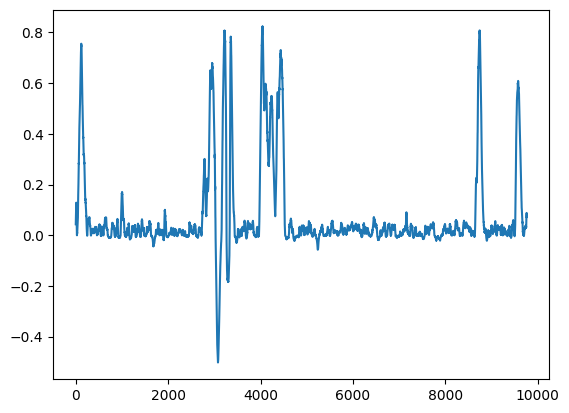

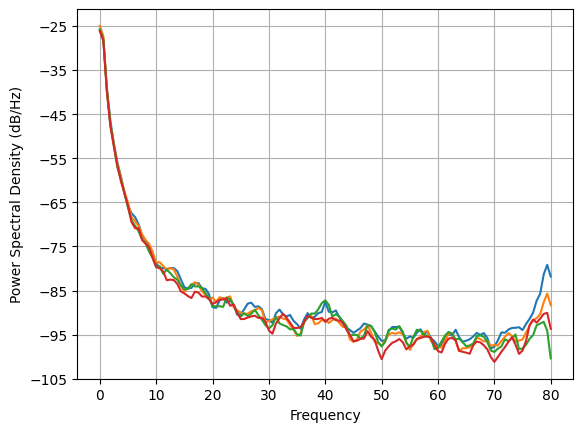

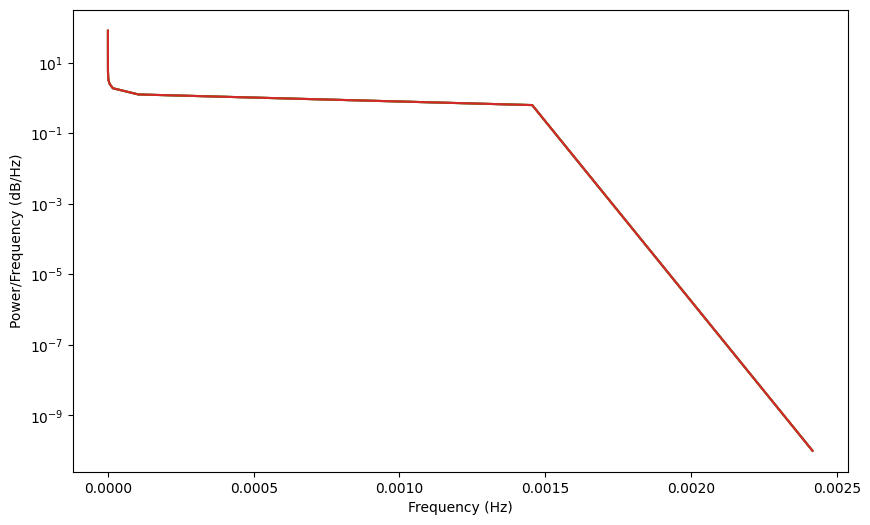

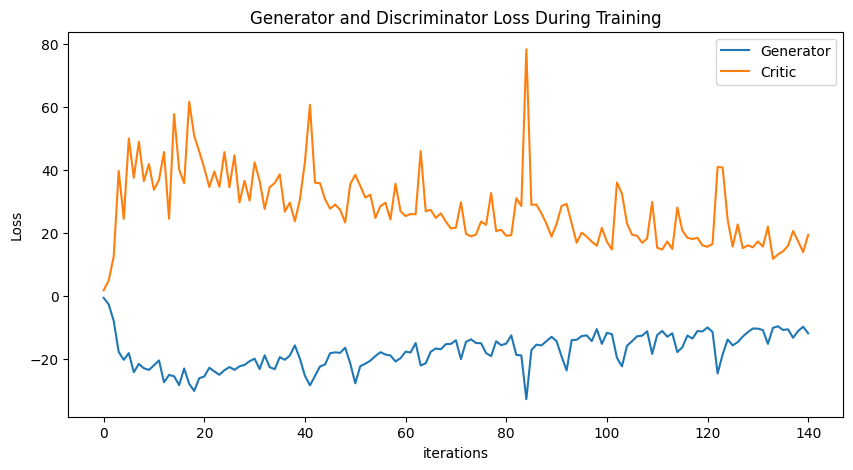

Epoch 150: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

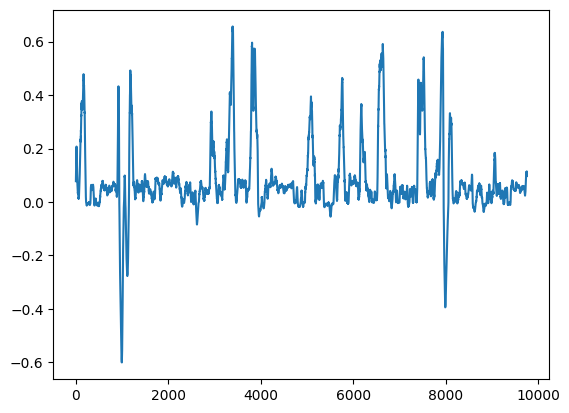

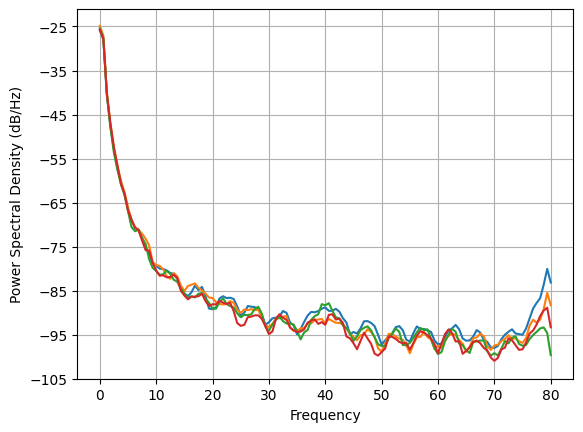

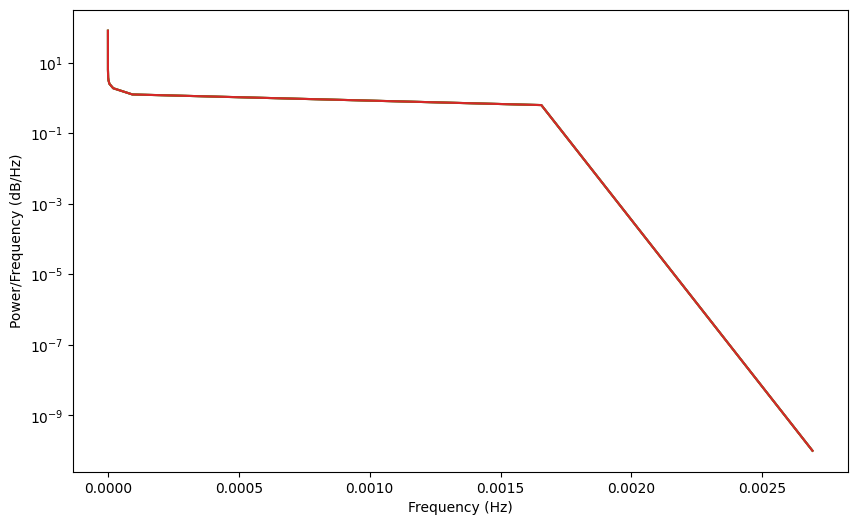

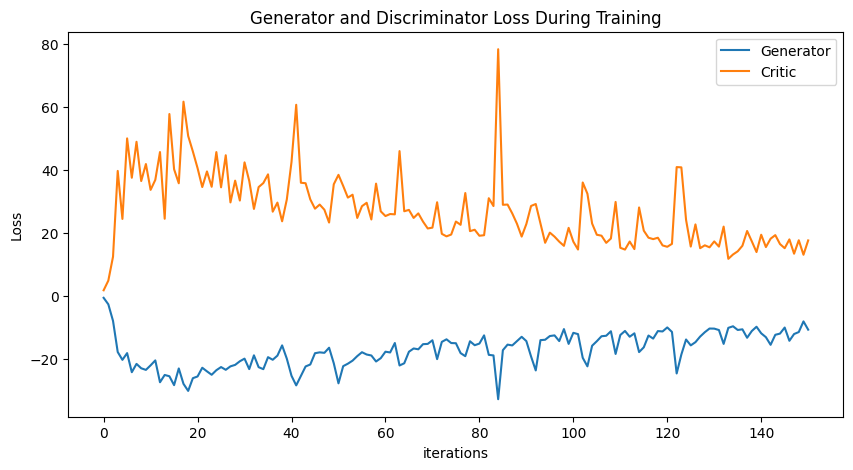

Epoch 160: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

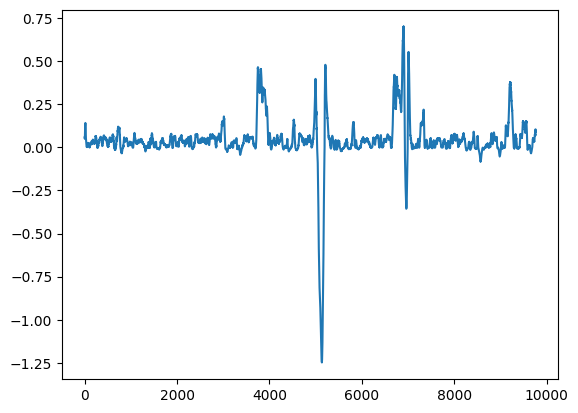

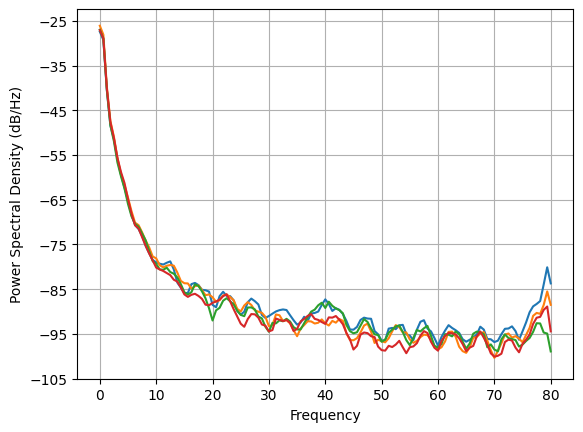

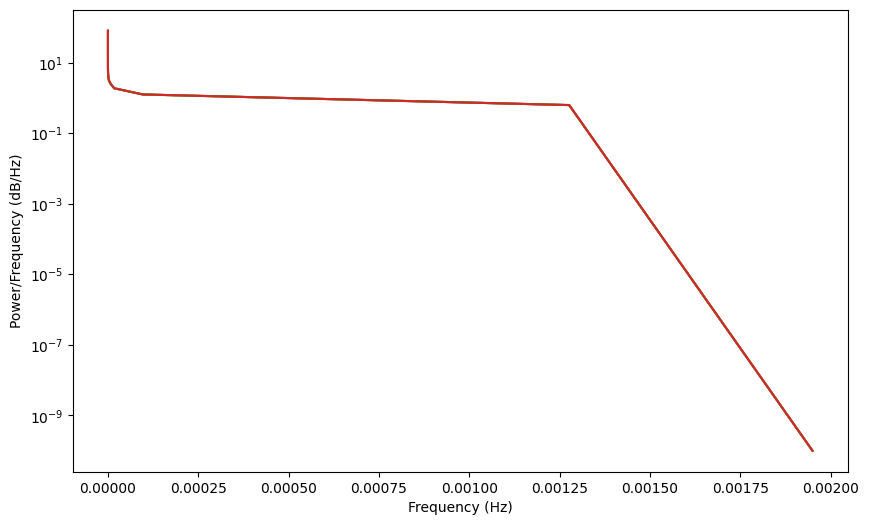

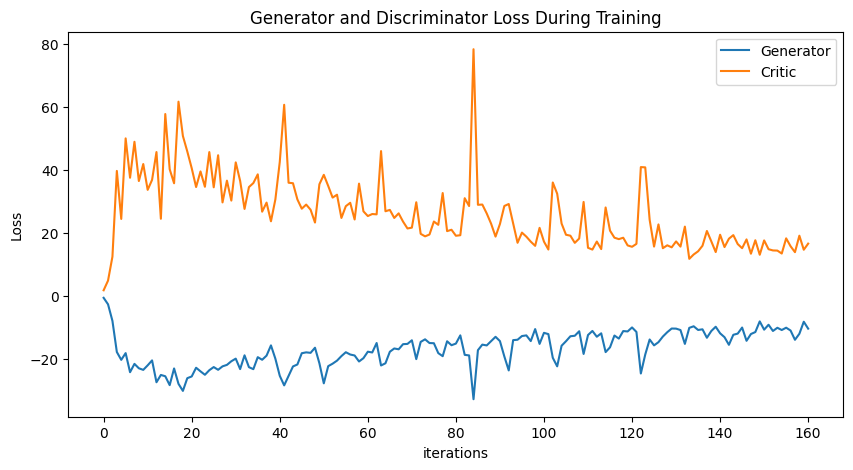

Epoch 170: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

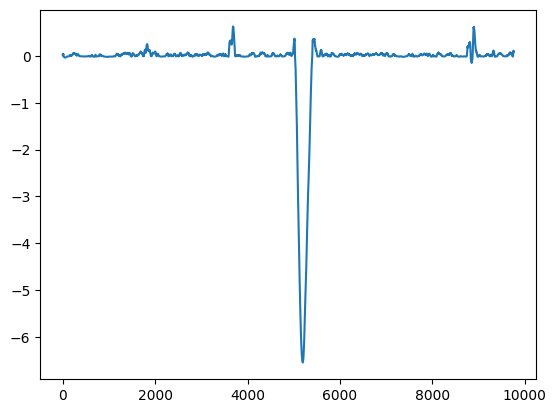

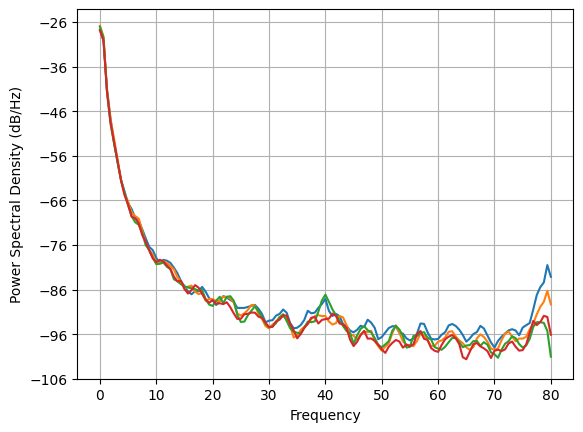

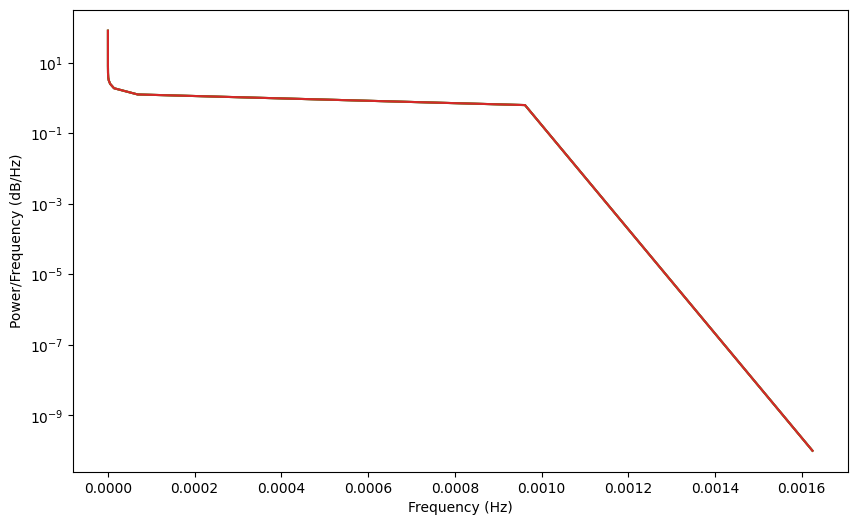

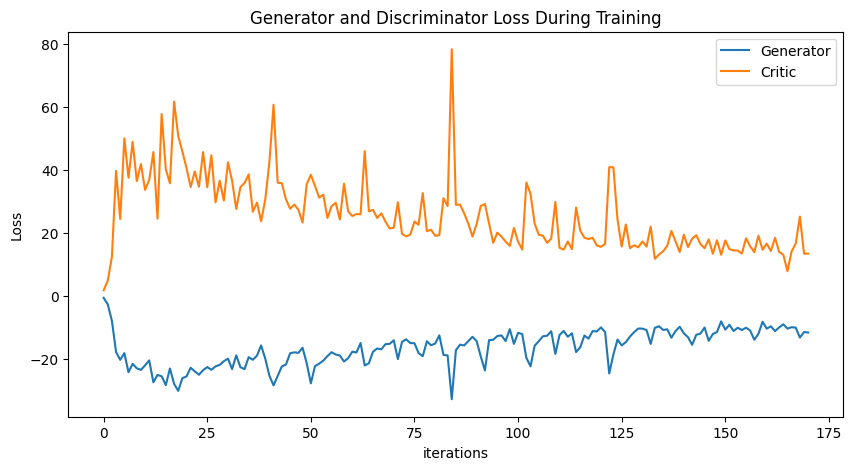

Epoch 180: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

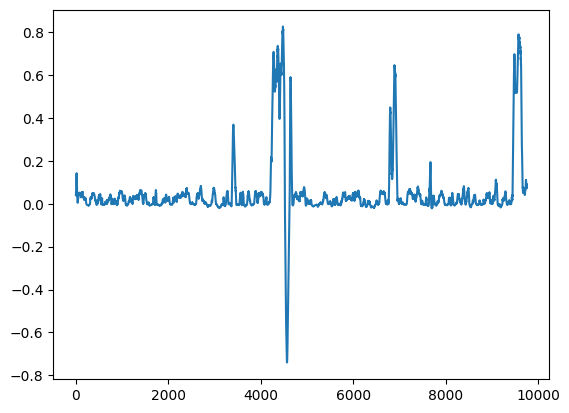

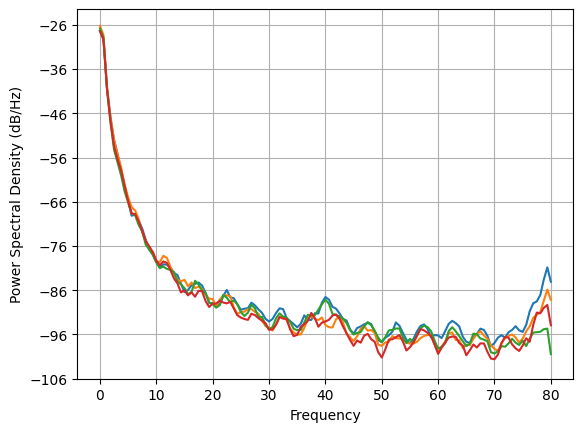

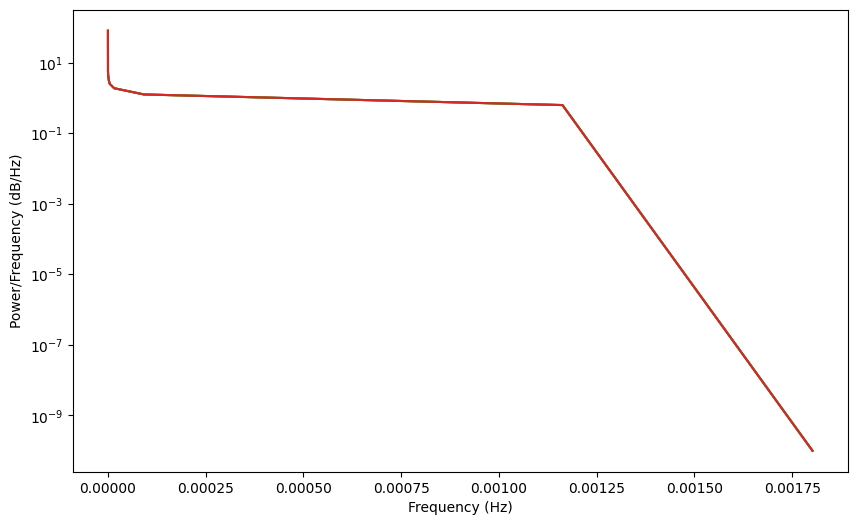

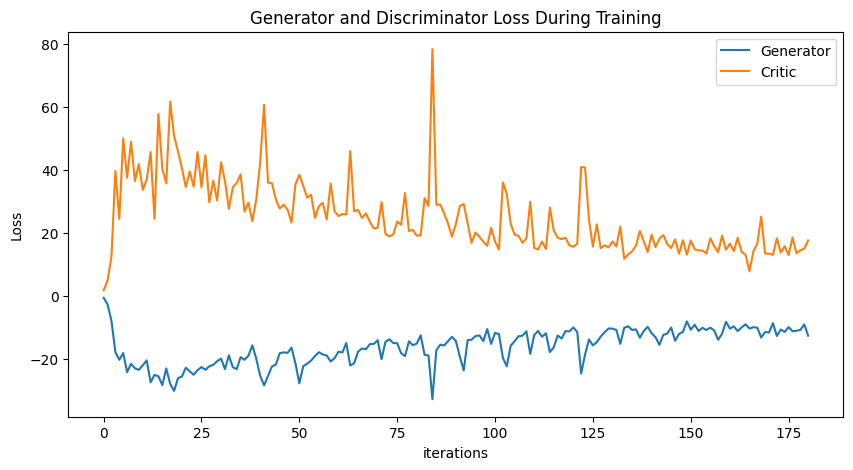

Epoch 190: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

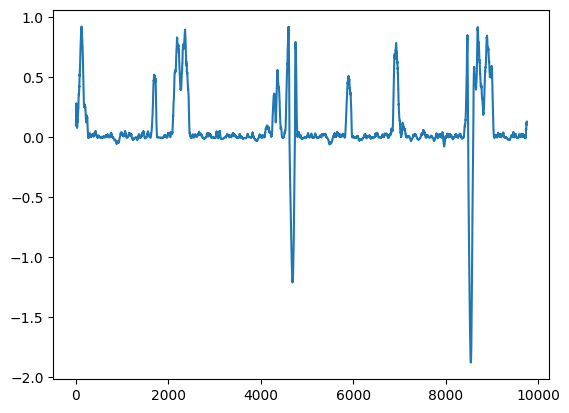

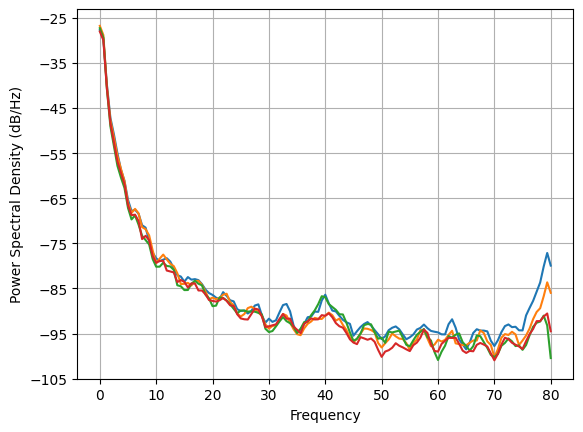

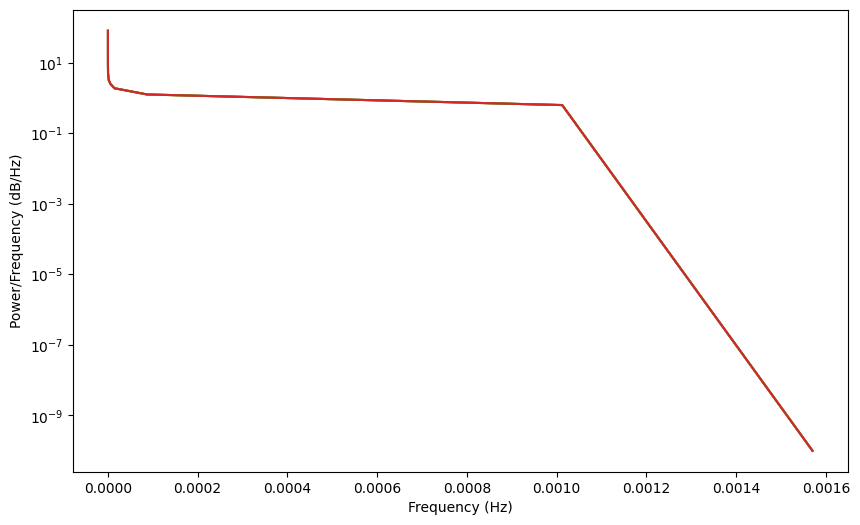

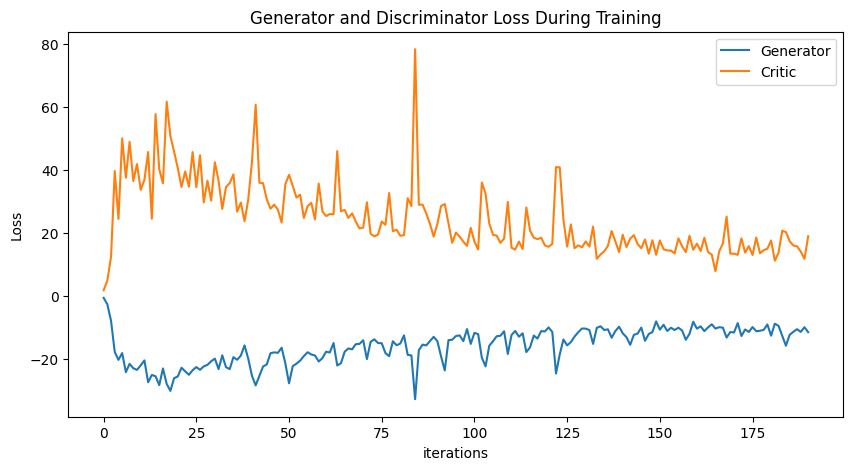

Epoch 200: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

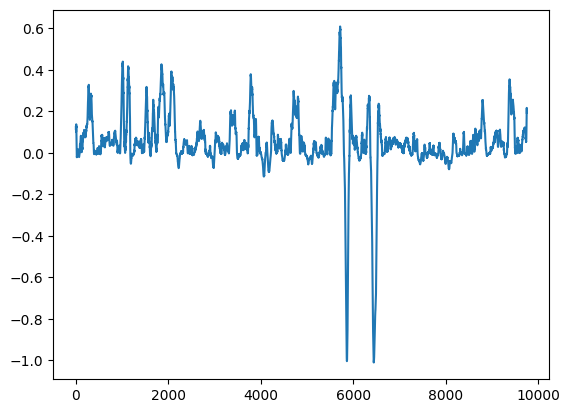

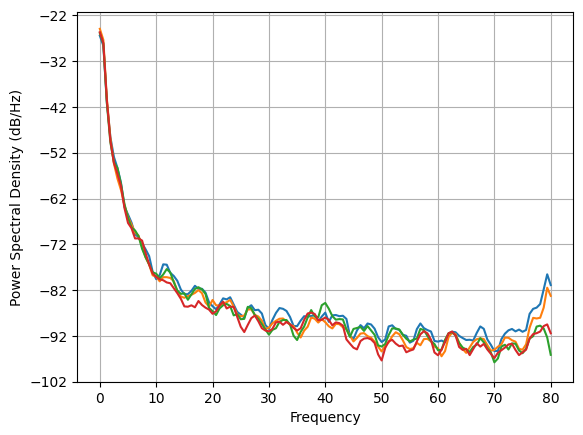

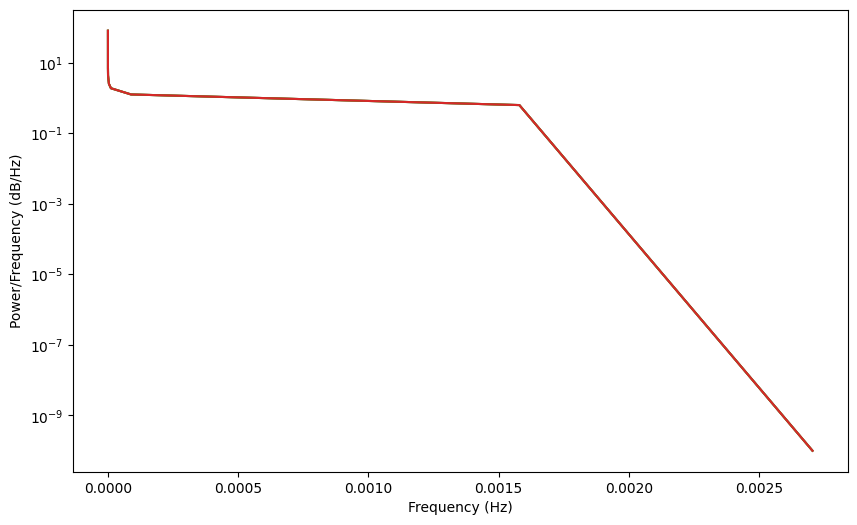

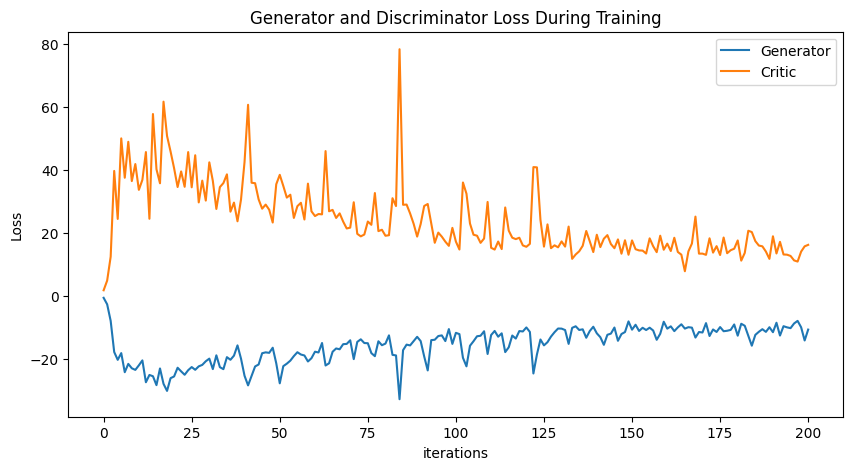

Epoch 210: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

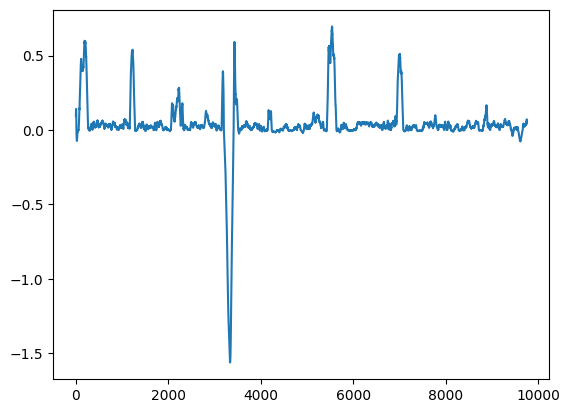

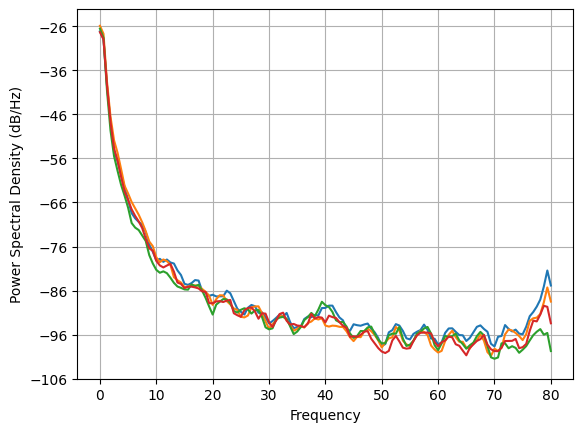

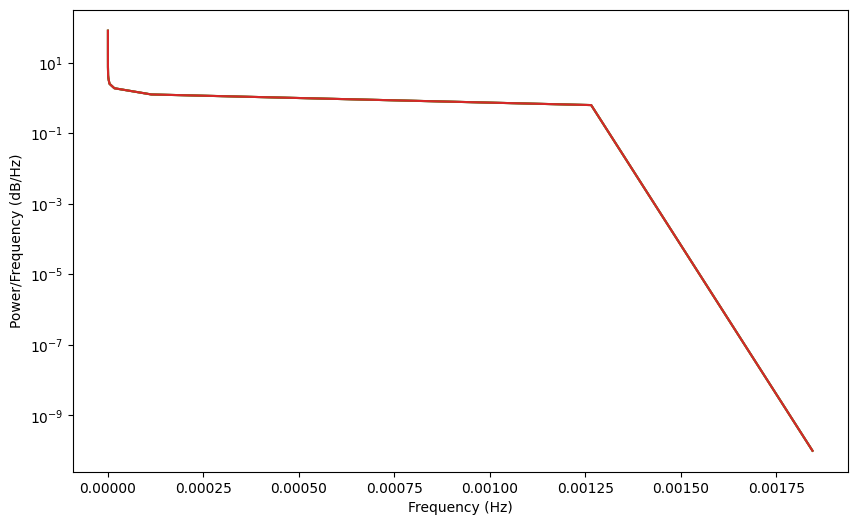

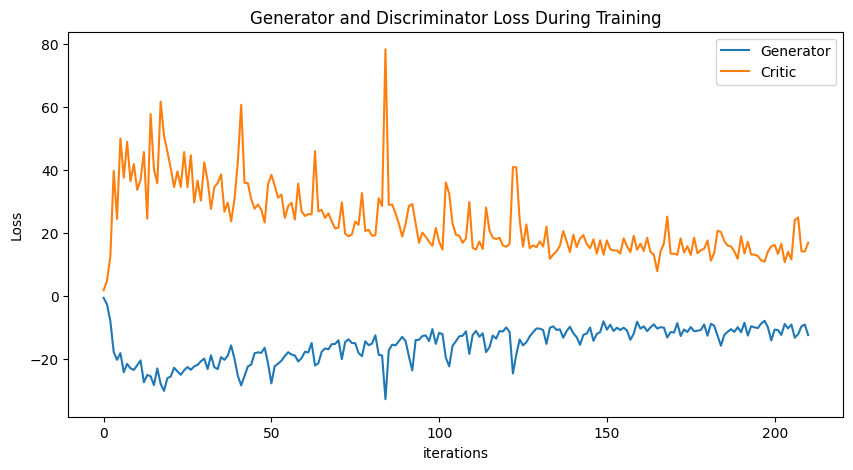

Epoch 220: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

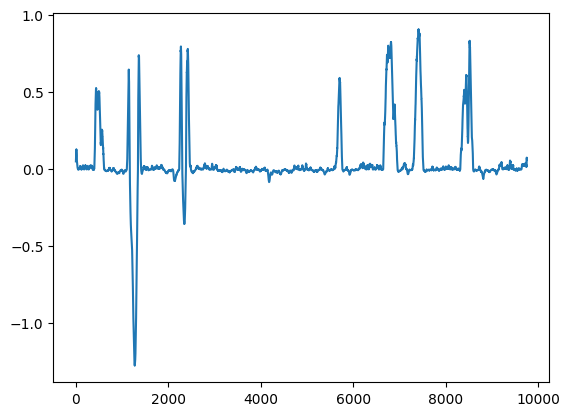

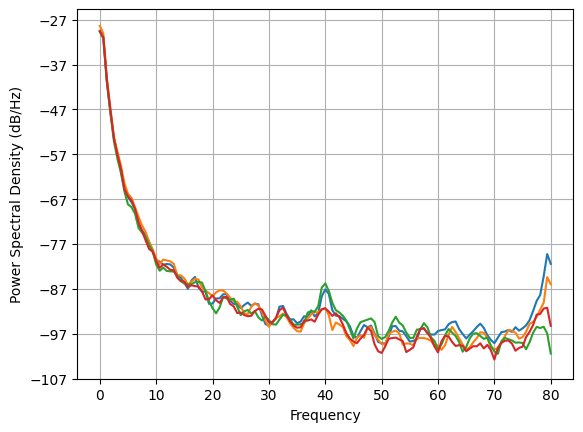

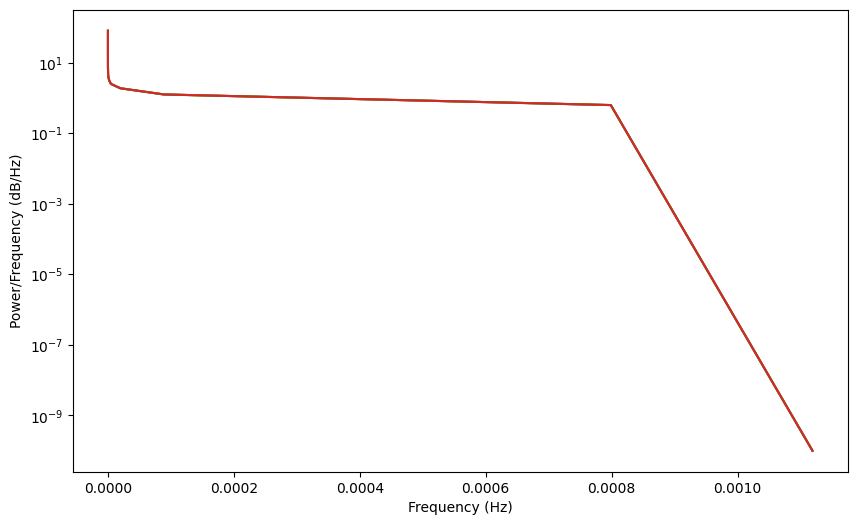

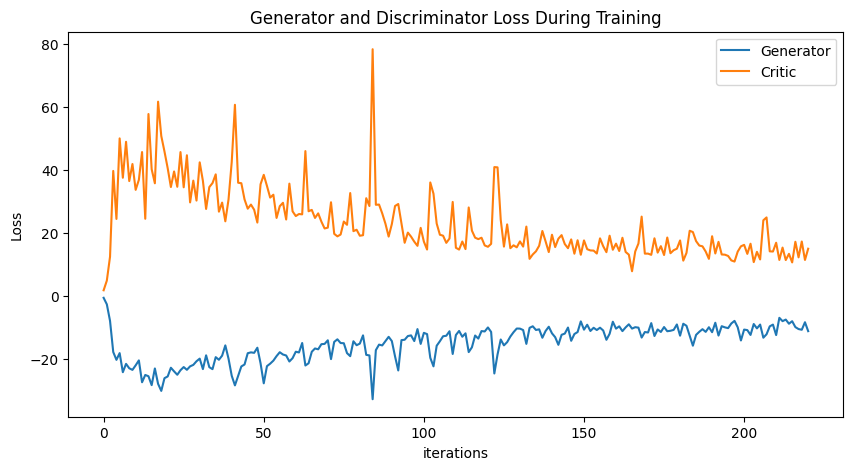

Epoch 230: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

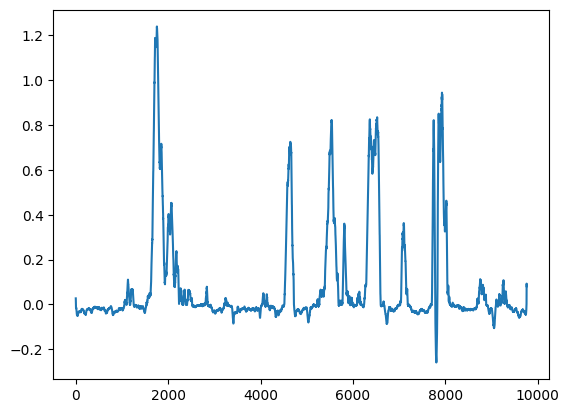

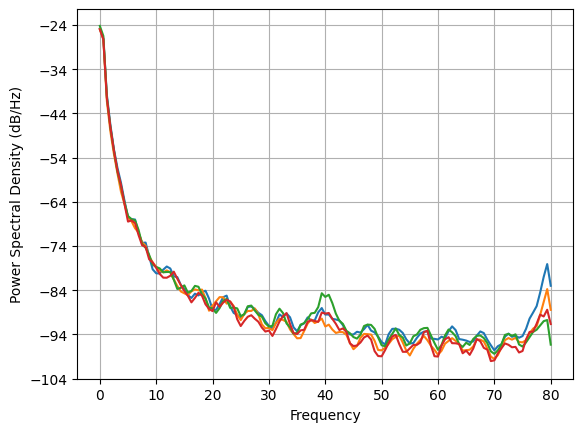

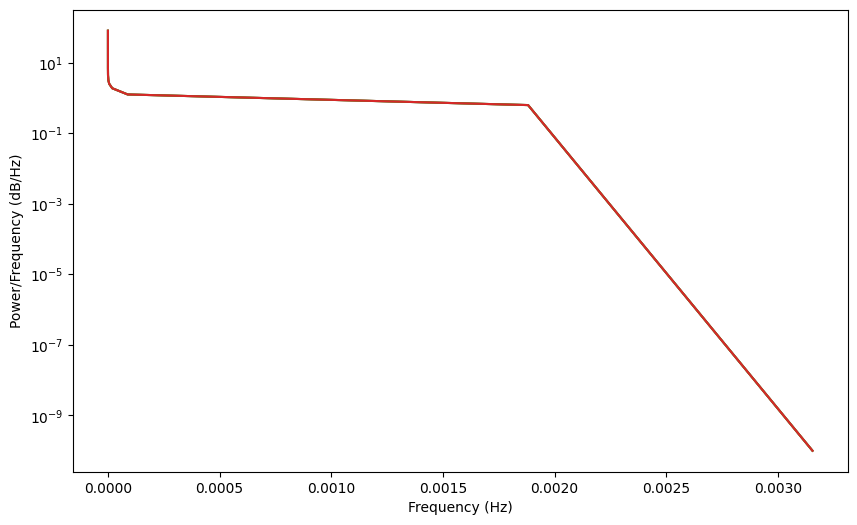

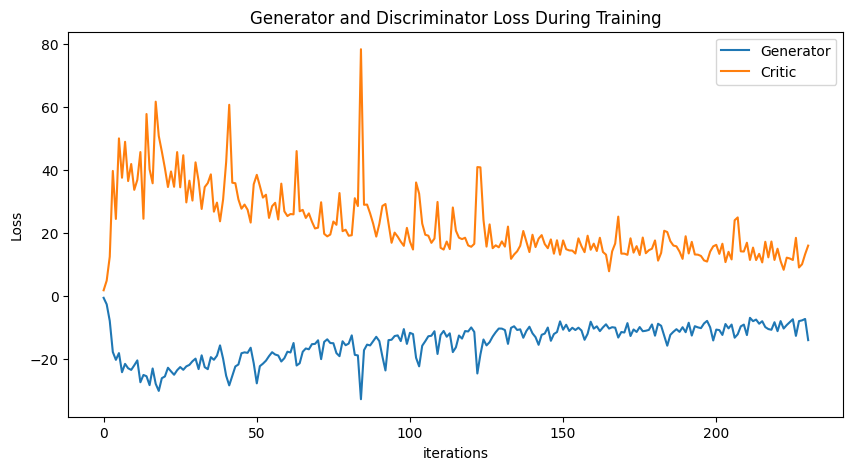

Epoch 240: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

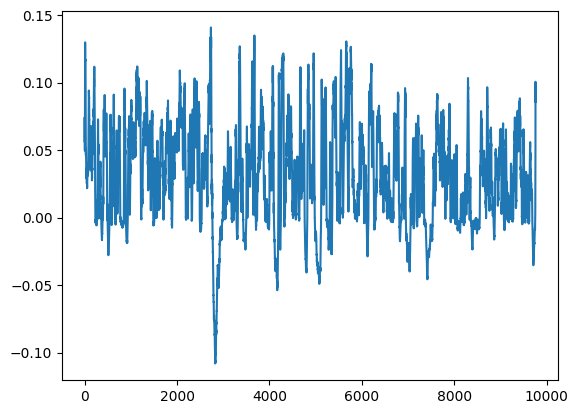

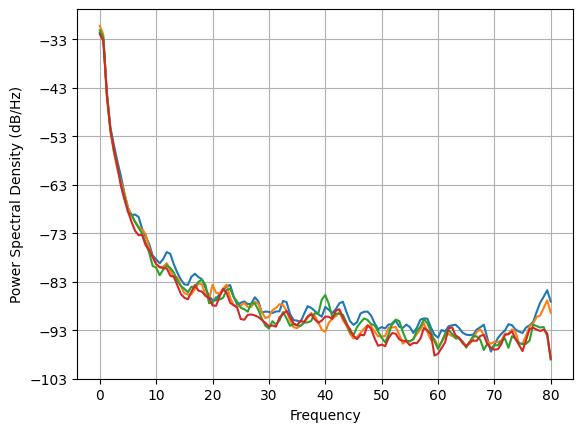

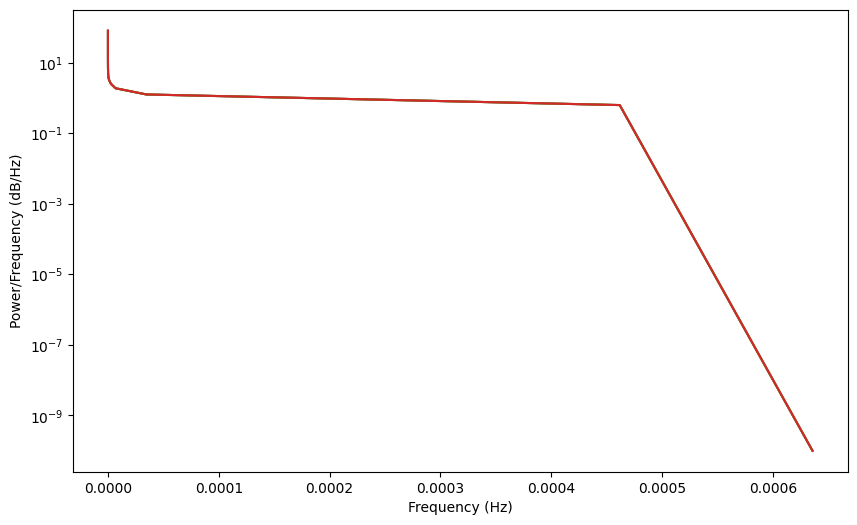

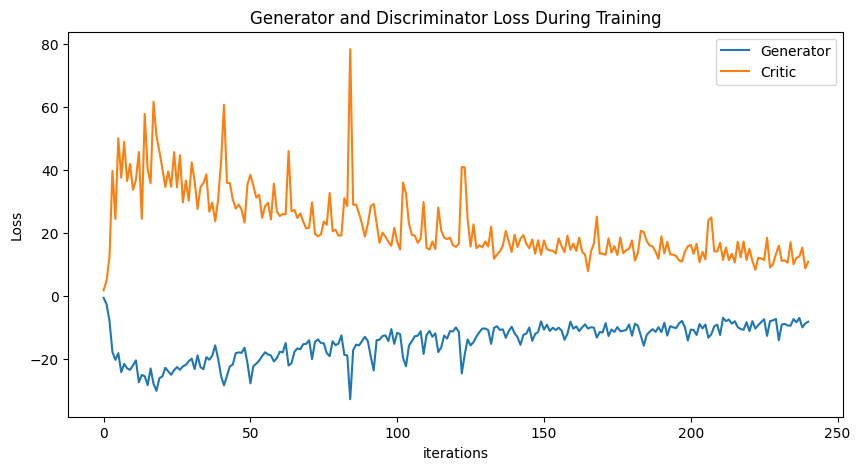

Epoch 250: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

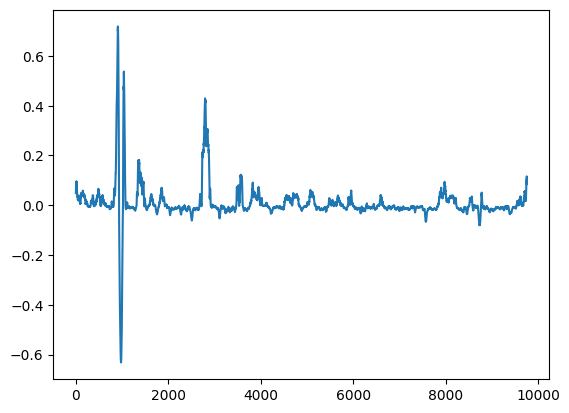

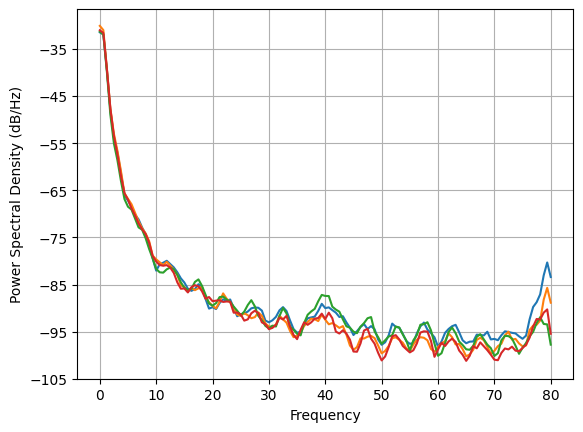

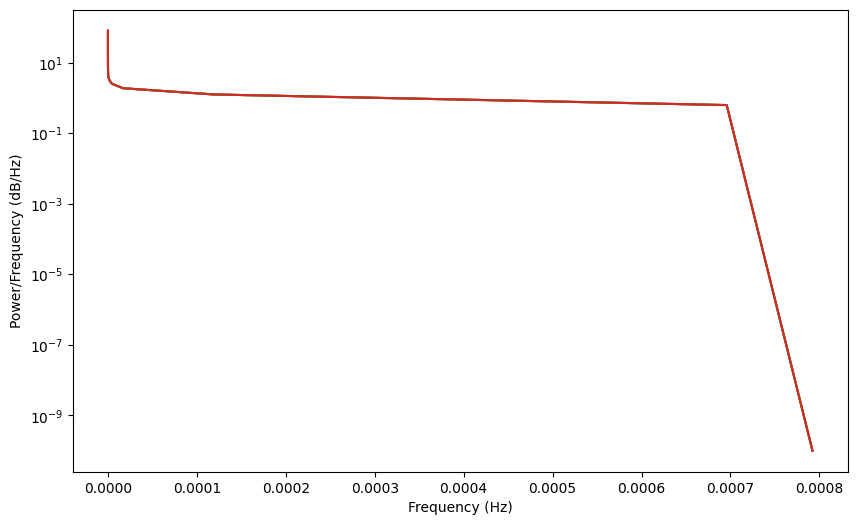

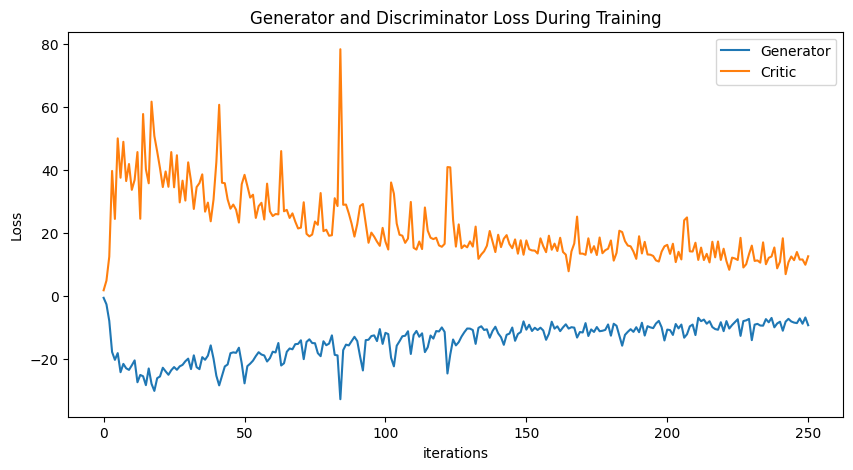

Epoch 260: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

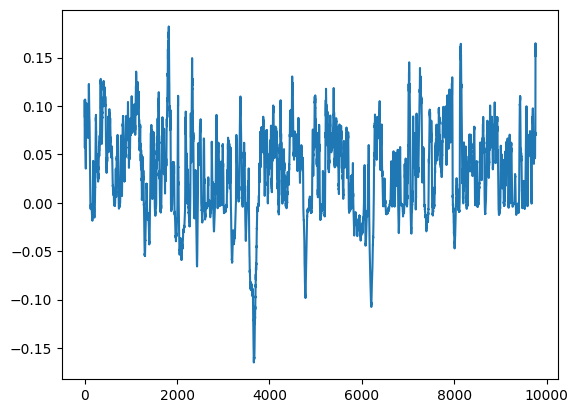

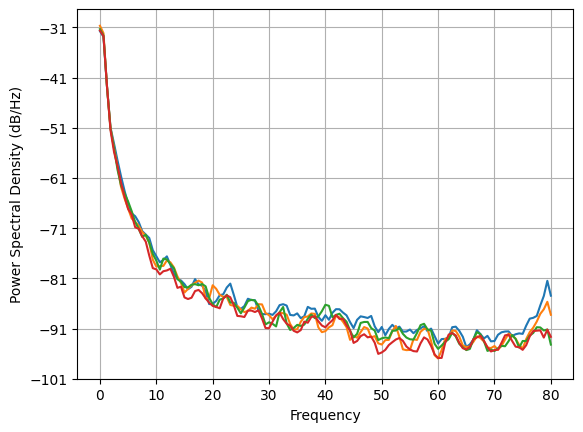

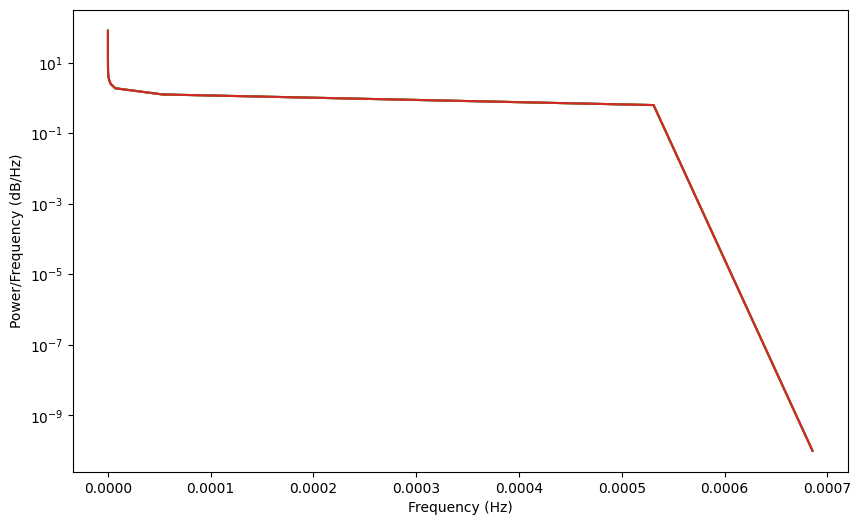

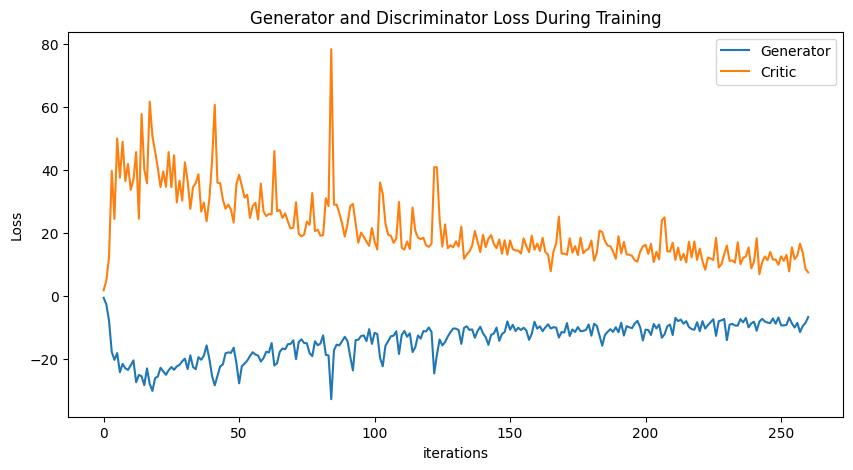

Epoch 270: Critic error ([-0.6483262013430188, -2.71425555298769, -7.984706575203903, -17.874066231102535, -20.366520306878414, -18.2265928725975, -24.293875112160585, -21.649012123427376, -23.048324365652444, -23.557201590089868, -22.113318140639237, -20.539482932409594, -27.489899774027457, -25.1701381446456, -25.577729714986884, -28.407789834256818, -23.102228502634254, -27.99105283084799, -30.237967763136105, -26.194202518967984, -25.647181722395242, -22.876151986275595, -24.026212292492694, -25.111722523246478, -23.659019973742815, -22.66070937492136, -23.531850557180352, -22.43575391185844, -21.968615964938387, -20.813754050267818, -19.981595957476046, -23.307113203982276, -18.928262544448014, -22.694859402528458, -23.32841447672478, -19.513263907327158, -20.34301647583508, -19.028178555190678, -15.768846025409117, -19.99602719386306, -25.43292458627218, -28.483062243177223, -25.442239512798466, -22.46435598776725, -21.843177805697216, -18.2600709665179, -17.98652731874789, -18.1

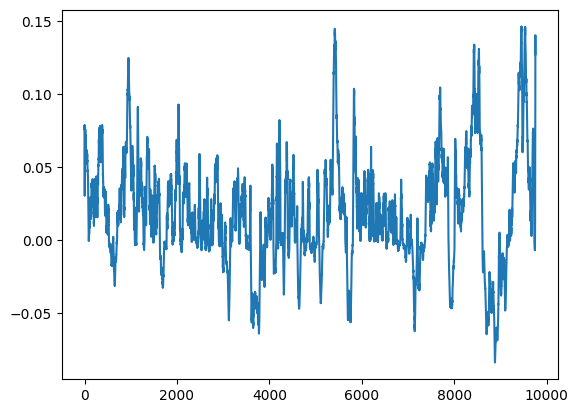

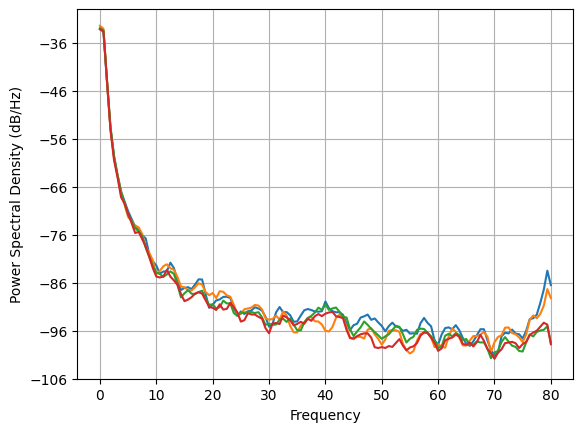

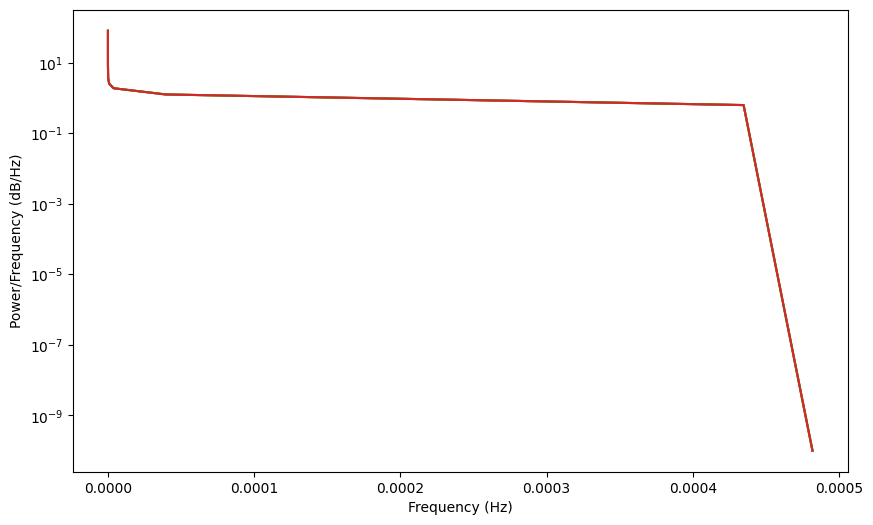

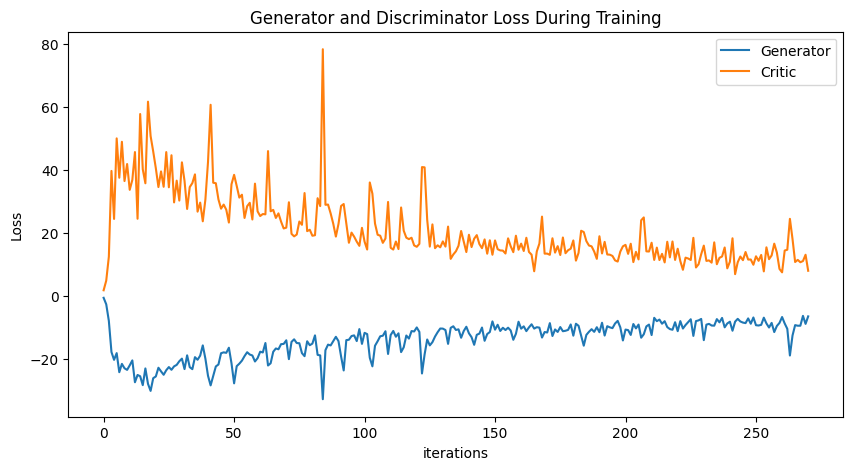

KeyboardInterrupt: 

In [6]:
NUM_EPOCHS = 300
PRINT_INTERVAL = 10
BATCH_SIZE = np.shape(training_data_closed)[0]
training_data = torch.tensor(training_data_closed)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(NUM_CHANNELS, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(NUM_CHANNELS, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 320, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 320, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_closed, disc, gen = train()

torch.save(gen, 'generator-4best-ch.pt')
torch.save(disc, 'discriminator-4best-ch.pt')
np.save('4best-ch.npy', generated_data_closed.detach())
plot_everything(generated_data_closed, gen_err, critic_err)
generated_data_closed = None

# kernel 20

In [ ]:
NUM_EPOCHS = 300
PRINT_INTERVAL = 10
BATCH_SIZE = np.shape(training_data_closed)[0]
training_data = torch.tensor(training_data_closed)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(320, 320, kernel_size=20),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=20),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=20),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=20),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=20),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 16, kernel_size=20),
            nn.BatchNorm1d(16, affine=True),
            nn.LeakyReLU(0.2),
            nn.Linear(10957, 9760)
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(16, 320, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 16, kernel_size=20),
            nn.LeakyReLU(0.2),
            nn.Linear(114, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 320, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 320, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_closed, disc, gen = train()

torch.save(gen, 'generator-4best-ch-k20.pt')
torch.save(disc, 'discriminator-4best-ch-k20.pt')
np.save('4best-ch-k20.npy', generated_data_closed.detach())
plot_everything(generated_data_closed, gen_err, critic_err)
generated_data_closed = None

# 4 best channels as training data (1500 epoch)

In [ ]:
NUM_EPOCHS = 1500
PRINT_INTERVAL = 100
BATCH_SIZE = np.shape(training_data_closed)[0]
training_data = torch.tensor(training_data_closed)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(320, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(320, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(NUM_CHANNELS, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(NUM_CHANNELS, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, 320, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(320, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)
            noise = sample_normal_distribution(BATCH_SIZE, 320, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty(D, real, fake) * LAMBDA_GP
            D.zero_grad()
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()  

        noise = sample_normal_distribution(BATCH_SIZE, 320, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated_data_closed, disc, gen = train()

torch.save(gen, 'generator-4best-ch-e1500.pt')
torch.save(disc, 'discriminator-4best-ch-e1500.pt')
np.save('4best-ch-e1500.npy', generated_data_closed.detach())
plot_everything(generated_data_closed, gen_err, critic_err)
generated_data_closed = None